# File that runs the MEOF analysis in python and then the hindcast AND cross validation calculations in fortran, and then analyzes those results in python.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
import matplotlib.patches as mpatches

%run utils.ipynb

# 1. Load in the model datasets: found in /d6/bxw2101/model_files/datasets.

## We want to load in the smoothed anomaly timeseries.

In [2]:
# LOAD SIC: 1x0.5
filename = '/d6/bxw2101/model_files/datasets/sic_1x0p5.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed

# LOAD 6 (for now) other model variables: 2x2
filename = '/d6/bxw2101/model_files/datasets/vars_2x2.nc'
vars_2x2 = xr.open_dataset(filename)
sst_anom = vars_2x2.sst_anom_smoothed    # 1
sat_anom = vars_2x2.sat_anom_smoothed    # 2
z_anom = vars_2x2.z_anom_smoothed        # 3
u_anom = vars_2x2.u_anom_smoothed        # 4
v_anom = vars_2x2.v_anom_smoothed        # 5
sthf_anom = vars_2x2.sthf_anom_smoothed  # 6

# File naming conventions, selecting # of vars:
var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']

#___ CHANGE the scaling here!
var_scaling = [2, 1, 1, 0.2, 0.2, 0.2, 1]
#var_scaling = [2, 1, 1, 1, 1, 1, 1]
#var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 0.5]

# GOAL: Get new stds's, then normalize anomalies, so now all of the anomaly std's are = 1. on same scale.

# Calculate new std's, save new stds into one array.
sic_std = sic_anom.std() / var_scaling[0]
sst_std = sst_anom.std() / var_scaling[1]
sat_std = sat_anom.std() / var_scaling[2]
z_std = z_anom.std() / var_scaling[3]
u_std = u_anom.std() / var_scaling[4]
v_std = v_anom.std() / var_scaling[5]
sthf_std = sthf_anom.std() / var_scaling[6]
stds = [sic_std, sst_std, sat_std, z_std, u_std, v_std, sthf_std]

# Normalize the anomalies, save normalized anomalies into one array
norm_sic_anom = sic_anom/sic_std
norm_sst_anom = sst_anom/sst_std
norm_sat_anom = sat_anom/sat_std
norm_z_anom = z_anom/z_std
norm_u_anom = u_anom/u_std
norm_v_anom = v_anom/v_std
norm_sthf_anom = sthf_anom/sthf_std

# Convert normalized anomalies to numpy normalizes anomalies.
np_sic_anom = norm_sic_anom.to_numpy()
np_sst_anom = norm_sst_anom.to_numpy()
np_sat_anom = norm_sat_anom.to_numpy()
np_z_anom = norm_z_anom.to_numpy()
np_u_anom = norm_u_anom.to_numpy()
np_v_anom = norm_v_anom.to_numpy()
np_sthf_anom = norm_sthf_anom.to_numpy()
np_vars = [np_sic_anom, np_sst_anom, np_sat_anom, np_z_anom, np_u_anom, np_v_anom, np_sthf_anom]

# Latitude weight creation
sic_wgts = np.cos(np.deg2rad(sic_anom_ds.coords['y'].values)).clip(0., 1.)[..., np.newaxis]
#     sic_wgts = np.cos(np.deg2rad(sic_anom_ds.y.data))[:, np.newaxis] also works.
vars_wgts = np.cos(np.deg2rad(vars_2x2.coords['y'].values)).clip(0., 1.)[..., np.newaxis]

# defining the different plotting regions right here, and boxing out rectangles for the two regions of interest that we show on poster (dp1, e2)
- we can and should change the eastern regions because I just made them up on my own LMFAO

In [3]:
# Defining the different regions in the Antarctic:
dp1_region = (sic_anom.y >= -70) & (sic_anom.y <= -60) & (sic_anom.x >= 210) & (sic_anom.x <= 230)
dp2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 320) & (sic_anom.x <= 340)
entire_region = True
# my own:
e1_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 0) & (sic_anom.x <= 20)
e2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 20) & (sic_anom.x <= 40)
e3_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 40) & (sic_anom.x <= 60)
e4_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 140) & (sic_anom.x <= 160)

# define validpoints: Ocean water where there is non-zero sea ice concentration > 5% of the time
filename = '/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_1x0p5.nc'
sic_ds = xr.open_dataset(filename)
sic_var = sic_ds.sic
# freq: Percent of time steps with any valid sea ice value.
freq = sic_var.isel(tdim=slice(2, 518)).where((sic_var < 2.51) & (sic_var > 0)).count(dim='tdim')/516
validpoints = (freq > 0.05)
# sic_anom = sic_anom.where(validpoints)
# HERE, WE DO NOT SET SIC_ANOM TO JUST VALIDPOINTS. MAYBE WE DO THIS BEFORE GETTING THE STDS. 6/13/23

def show_rectangle(ax, x, y, w, h):
    ax.add_patch(mpatches.Rectangle(xy=[x, y], width=w, height=h, 
                                    facecolor='blue', alpha=0.2, transform=pc))
    return ax

In [4]:
# Defining the seasons
seasons = ["DJF", "MAM", "JJA", "SON"]

# Load up the observed SIC anomalies, but chop to their correct time series, and take only valid points.
sic_obs_h = sic_anom.isel(tdim=slice(12, 516)).where(validpoints) # Chop off 1979.
sic_obs_c = sic_anom.isel(tdim=slice(12, 504)).where(validpoints) # Chop off 1979, 2021.
#avg_corrs, avg_rmse = leadtime_plot(2, dp1_region)

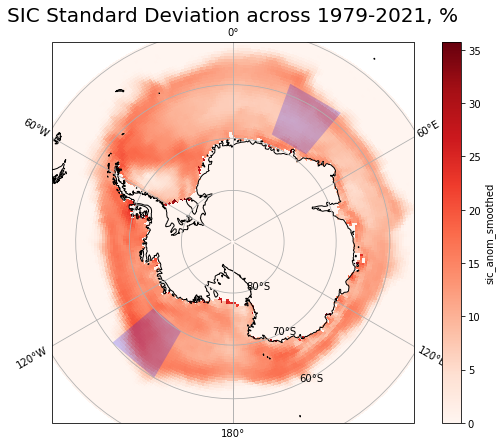

In [5]:
map_sic_std = sic_anom.std(dim='tdim')

# Plot where the region is:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
(map_sic_std * 100).plot(transform=pc, cmap='Reds') 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
show_rectangle(ax, 210, -70, 20, 10) #dp1 region
show_rectangle(ax, 20, -68, 20, 10) #e2 region
ax.set_title('SIC Standard Deviation across 1979-2021, %', fontsize = 20)
plt.show()

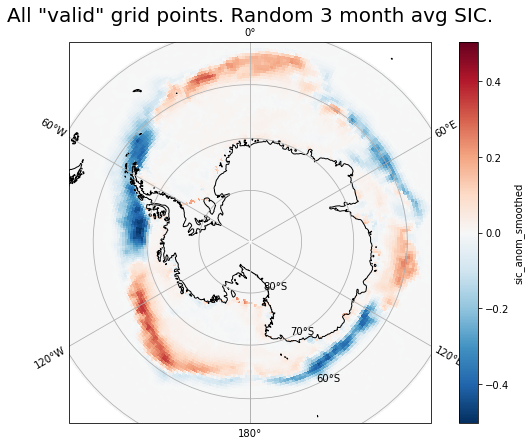

In [6]:
# A Plot of all valid lat/lon cells considered "Valid" in the SIC data
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
sic_anom.sel(tdim='2008-09-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title('All "valid" grid points. Random 3 month avg SIC.', fontsize=20)
plt.show()

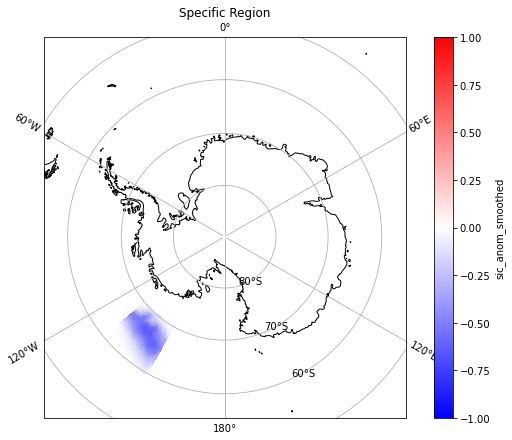

In [7]:
# Plot where a specific region is
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
sic_obs_h.where(dp1_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr') 
# fix the damn colorbar axis here. use vmin, vmax, cbarlim, etc. in hindcast_files_analysis.ipynb
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('Specific Region')
plt.show()

(Correlation testing code blocks in **correlation_rmse_testing.ipynb** go here)

# 2. Choose the # of variables and # of modes, to run the hindcast + cross validation markov model creation.

### define the setup_model function below

In [5]:
def setup_model(indices):
    model_vars = [np_vars[x] for x in indices]
    f_start = '_'.join([var_names[x] for x in indices])
    f_scal = '*'.join([str(var_scaling[x]) for x in indices])
    f_name = f_start + '-' + f_scal
    model_wgts = [sic_wgts]
    for x in range(len(indices)-1):
        model_wgts.append(vars_wgts)
    return model_vars, model_wgts, f_name

### HERE: Change the indices, corresponding to the variables you want to include in the model.

In [38]:
# reminder: var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']
indices = [0, 1, 2] # our best one we think: 0, 1, 2, 6
#indices = [0, 1, 2]
model_vars, model_wgts, f_name = setup_model(indices)
nv = len(indices)
print(f_name)

sic_sst_sat-2*1*1


### Run the MEOF solver, and hindcast/cross validation model building fortran code.

In [39]:
# We think modes 9-12 are pretty good. Stick w 9 maybe, for final model.
for modes in range(1,21):
    # Give the output a full file name in the format:
    # variables_separated_by_underscores - weights*separated*by*astericks - #ofmodes
    complete_fname = f_name+'-'+ str(modes) + '.nc'
    print('Building hcast and cross for: '+ complete_fname)
    
    # run the solver here.
    solver = MultivariateEof(model_vars,
                         weights = model_wgts, center=False)
    nvars = nv-1 # nvars: number of variables NOT sic. ex. sst, sat: nvars = 2. i=0, 1.
    
    #____________________Solve for MEOFs, PCs
    # define the lat, lon coordinates for the variables.
    sic_lat_bins = np.arange(-89.5, -49.5, 0.5)
    sic_lon_bins = np.arange(0., 360, 1)
    vars_lat_bins = np.arange(-88., -49, 2)
    vars_lon_bins = np.arange(0., 359, 2)

    # get the eofs, pcs, eigenvalues here.
    np_eofs_list = solver.eofs(neofs=modes) # scale by something here?
    np_eofscov_list = solver.eofsAsCovariance(neofs=modes)
    np_pcs = solver.pcs(npcs=modes)
    np_eigs = solver.eigenvalues(neigs=modes) 
    sum_eigs = solver.eigenvalues().sum()
    percent_var = np_eigs.sum() / solver.eigenvalues().sum()
    tav = solver.totalAnomalyVariance()
    vf = solver.varianceFraction()

    # turn the list of eofs for each variable used in the model into SIC_EOFs, and the rest of the eofs.
    sic_eofs = xr.DataArray(np_eofs_list[0],
                           coords = [np.arange(0, modes), sic_lat_bins, sic_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[0]
    all_vars_eofs = [sic_eofs] # all_vars_eofs is eventually what has all the eofs to be plotted.
    for i in range(nvars):
        all_vars_eofs.append(xr.DataArray(np_eofs_list[i + 1],
                           coords = [np.arange(0, modes), vars_lat_bins, vars_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[i + 1])
        
    # for each mode, get the pc timeseries for all the eofs.
    pcs = xr.DataArray(np_pcs, coords=[sic_anom.tdim, np.arange(0, modes)],
                      dims=['tdim', 'mode'])
    
    # Collapse sic_eofs and other eofs from 2d into 1d.
    stacked_sic_eofs = sic_eofs.stack(n=("y","x"))#28800 grid points
    all_stacked_eofs = [stacked_sic_eofs] # all_stacked_eofs is eventually all the stacked eofs.
    for i in range(nvars):
        all_stacked_eofs.append(all_vars_eofs[i+1].stack(n=("y", "x"))) #append a multiple of 3600 grid points
    meofs_2d = xr.concat(all_stacked_eofs, "n") 
    # save the collapsed meofs, and the PC timeseries into files to be ran with fortran.
    np.float32(meofs_2d.data).tofile("/d6/bxw2101/model_files/fortran_inputs/meofs")
    np.float32(pcs.transpose("mode", "tdim").data).tofile("/d6/bxw2101/model_files/fortran_inputs/pcs")
    numsic = len(stacked_sic_eofs.n)
    numpoints = len(meofs_2d.n)
    nummonths = len(pcs.tdim)
    
    #____________________Run for fortran code
    # Rewrites the input.h file for hindcast creation
    f = open("/home/bxw2101/hindcast/input.h", "w") 
    inputstr = '''\tPARAMETER(NT=(2021-1979+1)*12,NV='''+str(nv)+''',NL=12,
     % IX1=360,JY1=80,IX2=180,JY2=20,NC=''' + str(modes) + ''',NTY=43,
     % NX1=IX1*JY1,NX2=IX2*JY2,NXT=NX1+NX2*(NV-1),
     % N1=NT,N2=NXT)\n\n'''
    f.write(inputstr)
    f.close()
    
    # Rewrites the input.h file for cross-validation creation
    f = open("/home/bxw2101/cross/input.h", "w") 
    inputstr = '''\tPARAMETER(NT=(2021-1979+1)*12,NV='''+str(nv)+''',NL=12,
     % IX1=360,JY1=80,IX2=180,JY2=20,NC=''' + str(modes) + ''',NTY=43,
     % NX1=IX1*JY1,NX2=IX2*JY2,NXT=NX1+NX2*(NV-1),
     % N1=NT,N2=NXT)\n\n'''
    f.write(inputstr)
    f.close()
    
    
    # compiles the ./hcast file, runs the ./hcast file. 
    os.system('cd /home/bxw2101/hindcast; rm -f hcast; make; ./hcast')
    print('\t./hcast file finished')
    # compiles the ./cross file, runs the ./cross file.
    os.system('cd /home/bxw2101/cross; rm -f cross; make; ./cross')
    print('\t./cross file finished')
    #os.system('ls')
    #os.system('ls')
    
    
    #____________________Retrieve fortran output, turn into python dataarrays. Save zz to file.
    # fortran saves an extra 4 bytes at the front and end to denote logical size: remove them.
    filename = '/home/bxw2101/hindcast/trans_matrices'
    tmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    filename = '/home/bxw2101/hindcast/hcast_matrix'
    hmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    filename = '/home/bxw2101/cross/cross_matrix'
    cmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    
    
    # Load the hindcast transition matrices. in fortran, they are of the form aa(nc, nc, 12)
    aa = np.empty([12, modes, modes])
    for m_i in range(12):
        i_1 = m_i*modes**2
        i_2 = (m_i+1)*modes**2
        a_f = np.reshape(tmat[i_1:i_2], (modes, modes), order='F')
        aa[m_i] = a_f
    #aa currently is not doing anything. we just have, but we do not need.
    # Load the full hindcast array for SIC. in fortran: it is of the form zz(13, nx, nt)
    zz = np.empty([nummonths, 13, numpoints])
    for t_i in range(nummonths):
        i_1 = t_i*numpoints*13
        i_2 = (t_i+1)*numpoints*13
        zz[t_i] = np.reshape(hmat[i_1: i_2], (13, numpoints), order='F')
    zz_da = xr.DataArray(zz,
                           coords = [pcs.tdim, np.arange(13), meofs_2d.n],
                            dims=['tdim', 'lead', 'n'])
    # Load the full cross validation array for SIC. in fortran: it is of the form zz(13, nx1-sic, nt)
    zzc = np.empty([nummonths, 13, numsic])
    for t_i in range(nummonths):
        i_1 = t_i*numsic*13
        i_2 = (t_i+1)*numsic*13
        zzc[t_i] = np.reshape(cmat[i_1: i_2], (13, numsic), order='F')
    zzc_da = xr.DataArray(zzc,
                           coords = [pcs.tdim, np.arange(13), stacked_sic_eofs.n],
                            dims=['tdim', 'lead', 'n'])
    
    # hcast: unstack from 1d num of points back to the original 2d grids of lat/lon.
    stacked_sic_hcast = zz_da.isel(n=slice(0, len(stacked_sic_eofs.n)))
    all_stacked_hcasts = [stacked_sic_hcast] # HERE, we store hcasts in all_stacked_hcasts.
    for i in range(nvars):
        all_stacked_hcasts.append(zz_da.isel(n=slice(len(stacked_sic_eofs.n) + 3600*i, len(stacked_sic_eofs.n) + 3600*(i+1)))) 
    sic_hcast = stacked_sic_hcast.unstack()
    hcastwgts = np.cos(np.deg2rad(sic_hcast.y))
    sic_hcast = sic_hcast / hcastwgts
    sic_hcast = sic_hcast.isel(tdim=slice(12,516))
       
    # save the sic_hcast, the rest of the hcasts should be saved too in the future ig for the plots.
    os.system('cd /d6/bxw2101/model_files/hcast_output; rm -f '+complete_fname)
    sic_hcast.to_netcdf('/d6/bxw2101/model_files/hcast_output/'+complete_fname, mode='w',format='NETCDF4')

    # cross: unstack from 1d num of points back to the original 2d grids of lat/lon.
    sic_cross = zzc_da.unstack()
    hcastwgts = np.cos(np.deg2rad(sic_cross.y))
    sic_cross = sic_cross / hcastwgts
    sic_cross = sic_cross.isel(tdim=slice(12,504))
 
    # save the sic_cross, the rest of the cross's should be saved too in the future ig for the plots.
    os.system('cd /d6/bxw2101/model_files/cross_output; rm -f '+complete_fname)
    sic_cross.to_netcdf('/d6/bxw2101/model_files/cross_output/'+complete_fname, mode='w',format='NETCDF4')
    
    print('hcast and cross saved for: ' + complete_fname + '\n')

print('Done!')

Building hcast and cross for: sic_sst_sat-2*1*1-1.nc
gfortran -O2 hcast.f ../imsl/imsl.a -o hcast
	./hcast file finished
gfortran -O2 cross.f ../imsl/imsl.a -o cross
	./cross file finished
hcast and cross saved for: sic_sst_sat-2*1*1-1.nc

Building hcast and cross for: sic_sst_sat-2*1*1-2.nc
gfortran -O2 hcast.f ../imsl/imsl.a -o hcast
	./hcast file finished
gfortran -O2 cross.f ../imsl/imsl.a -o cross
	./cross file finished
hcast and cross saved for: sic_sst_sat-2*1*1-2.nc

Building hcast and cross for: sic_sst_sat-2*1*1-3.nc
gfortran -O2 hcast.f ../imsl/imsl.a -o hcast
	./hcast file finished
gfortran -O2 cross.f ../imsl/imsl.a -o cross
	./cross file finished
hcast and cross saved for: sic_sst_sat-2*1*1-3.nc

Building hcast and cross for: sic_sst_sat-2*1*1-4.nc
gfortran -O2 hcast.f ../imsl/imsl.a -o hcast
	./hcast file finished
gfortran -O2 cross.f ../imsl/imsl.a -o cross
	./cross file finished
hcast and cross saved for: sic_sst_sat-2*1*1-4.nc

Building hcast and cross for: sic_sst_sa

### Show the first five modes, and the first [modes] pcs. may include in final poster.
- Scaling to the maximum real value it represents right now.
- Figure out how to show the colorbars well. Also, figure out vmin and vmax for the rest of the variables.

[2353.70487073 1661.18667457 1293.13068622 1015.46558486  862.13387063
  743.57266648  693.39413231  567.40398776  536.89885889  499.56982663
  443.99513889  409.1362452   361.81649574  344.54670439  330.79658132
  292.71886034  261.5341446   250.64473322  241.85940341  217.85890009]


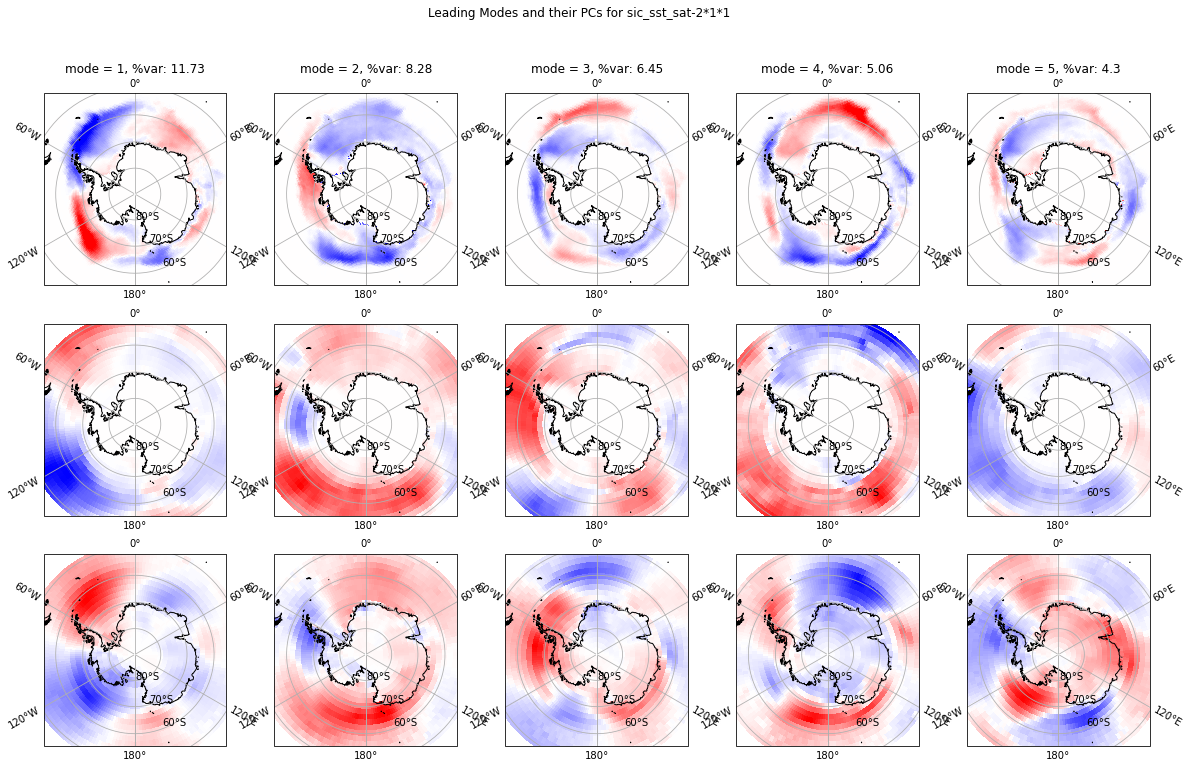

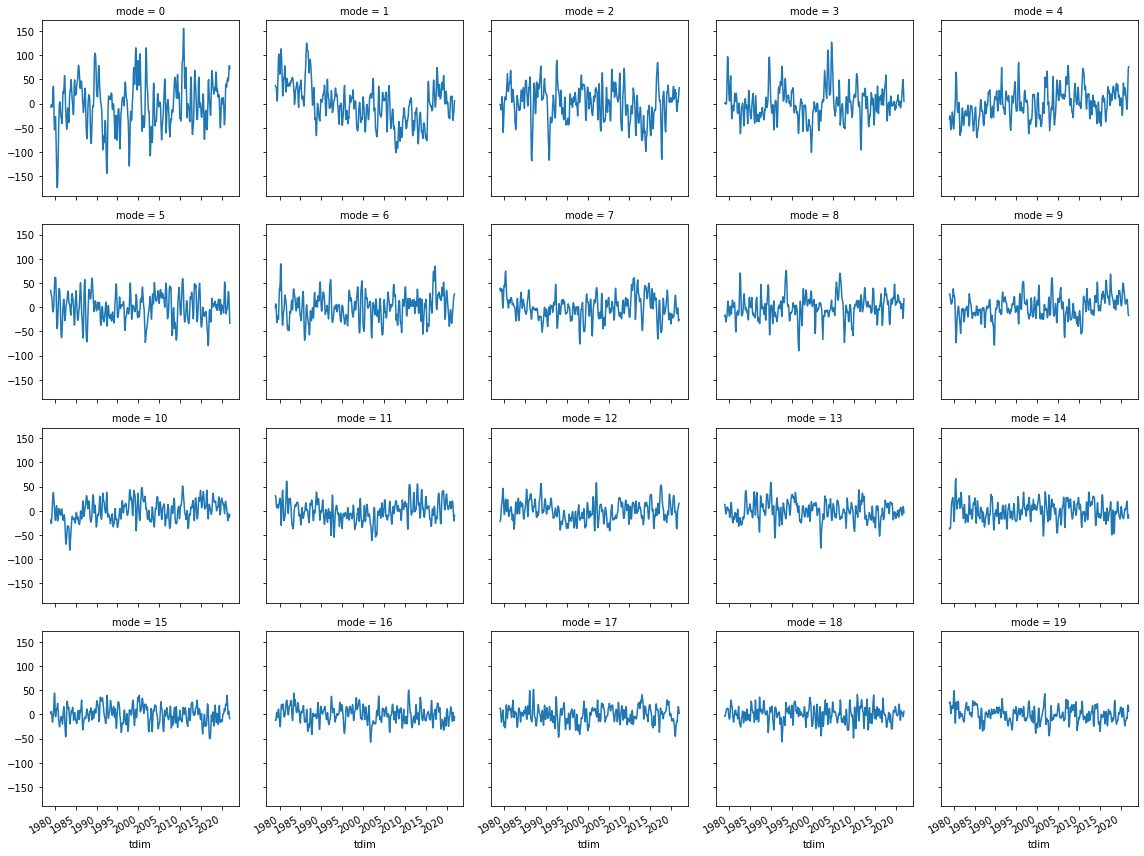

In [40]:
fig = plt.figure(figsize=(20,12))
for mode in range(min(5,modes)):
    # SIC EOFs
    ax = plt.subplot(len(indices), 5, mode + 1, projection=sp)
    # take the maximum real value it represents. (vmin = -.3, vmax = .3 is arbitrary. helps tho.)
    sic_mode = sic_eofs[mode]*pcs.sel(mode=mode).max()*var_scaling[0]
    im = sic_mode.plot(transform=pc, vmin=-.3, vmax=.3, cmap = 'bwr', add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('mode = ' + str(mode+1) + ', %var: ' + str(round(np_eigs[mode]/sum_eigs * 100, 2)))

    
    #OTHER VAR EOFS: all_vars_eofs[i+1] for i in range(nvars)
    for i in range(nvars):
        ax = plt.subplot(len(indices), 5, mode + 1 + 5*(i+1), projection=sp)
        vars_mode = all_vars_eofs[i + 1][mode]*pcs.sel(mode=mode).max()*var_scaling[indices[i]]
        im = vars_mode.plot(transform=pc, cmap = 'bwr', add_colorbar=False)
        
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        ax.set_title('')
plt.suptitle('Leading Modes and their PCs for ' + f_name)

# Plot corresponding PCs
if modes > 1:
    pcs.plot(x='tdim',col='mode',col_wrap=min(5, modes));
print(solver.eigenvalues(neigs=modes))

# 3. Evaluating hindcast/cross validation model skill: 
# To select the best model: comparing diff modes, & diff vars. & diff weights.

# Running Tests

### Running thru # of modes being 1-20, just like in the model creation loop:

# of zz matrices to plot: 7
Loaded in sic_sst_sat-2*1*1-5.nc
Loaded in sic_sst_sat-2*1*1-6.nc
Loaded in sic_sst_sat-2*1*1-7.nc
Loaded in sic_sst_sat-2*1*1-8.nc
Loaded in sic_sst_sat-2*1*1-9.nc
Loaded in sic_sst_sat-2*1*1-10.nc
Loaded in sic_sst_sat-2*1*1-11.nc


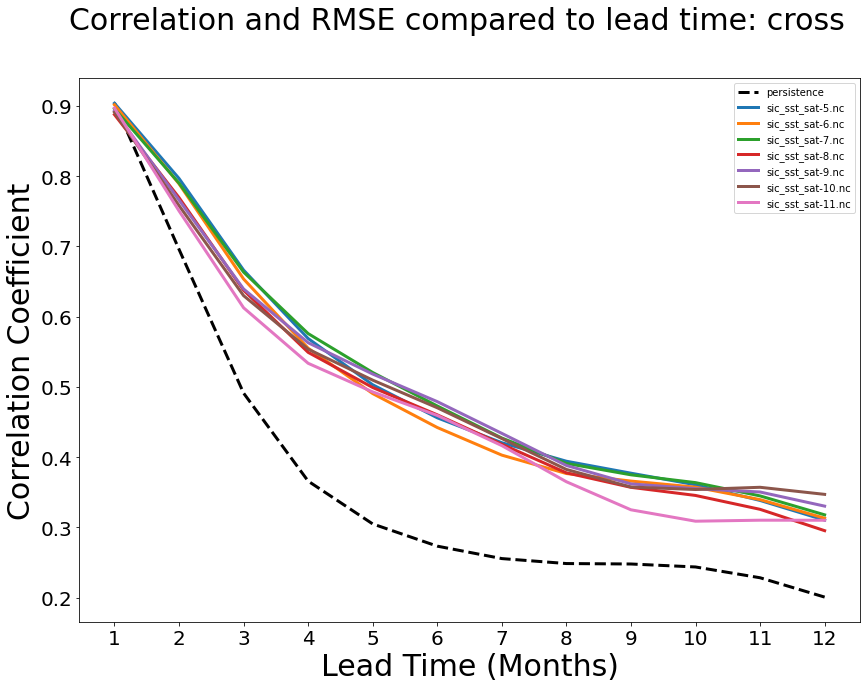

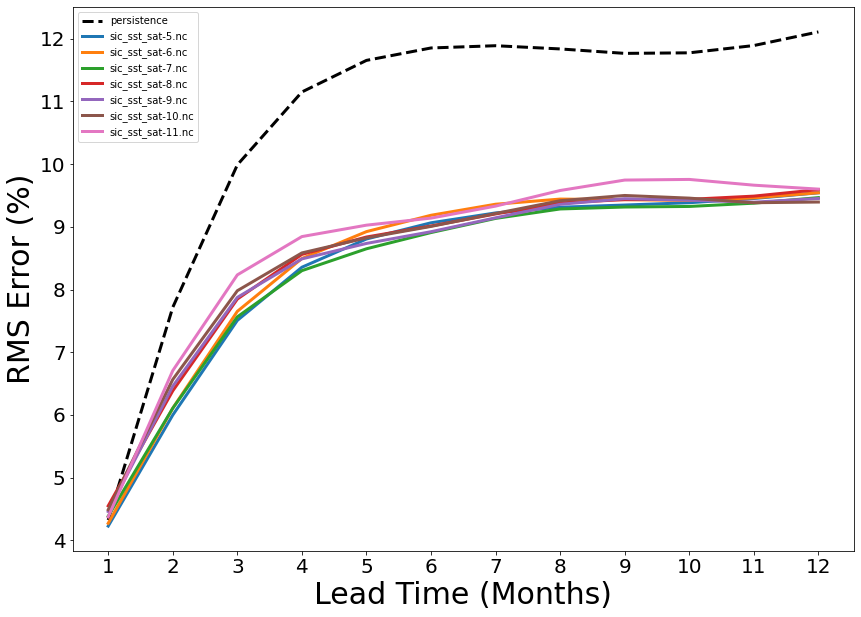

Saved all files!


In [44]:
# Define your variables
#f_name = 'sic_sst_sat_sthf-2*1*1*1' 
matrix_type = 'cross'
mode_comparison = [f_name+'-'+str(i)+'.nc' for i in range(5, 12)]

#Run the plots
ac, ar = leadtime_plot(matrix_type, mode_comparison, dp1_region)

# Save your correlation and rmse files
os.chdir('/d6/bxw2101/model_files/'+matrix_type+'_analysis/dp1_region/')
if not os.path.exists(f_name):
    os.mkdir(f_name)
for i in range (len(mode_comparison)):
    np.savetxt('/d6/bxw2101/model_files/'+matrix_type+'_analysis/'+'dp1_region/'+f_name+'/'+mode_comparison[i][:-3]+'-corr.txt', ac[i], delimiter=',')
    np.savetxt('/d6/bxw2101/model_files/'+matrix_type+'_analysis/'+'dp1_region/'+f_name+'/'+mode_comparison[i][:-3]+'-rmse.txt', ar[i], delimiter=',')
print('Saved all files!')



# of zz matrices to plot: 9
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-3.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-4.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-5.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-6.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-7.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-8.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-9.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-10.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc


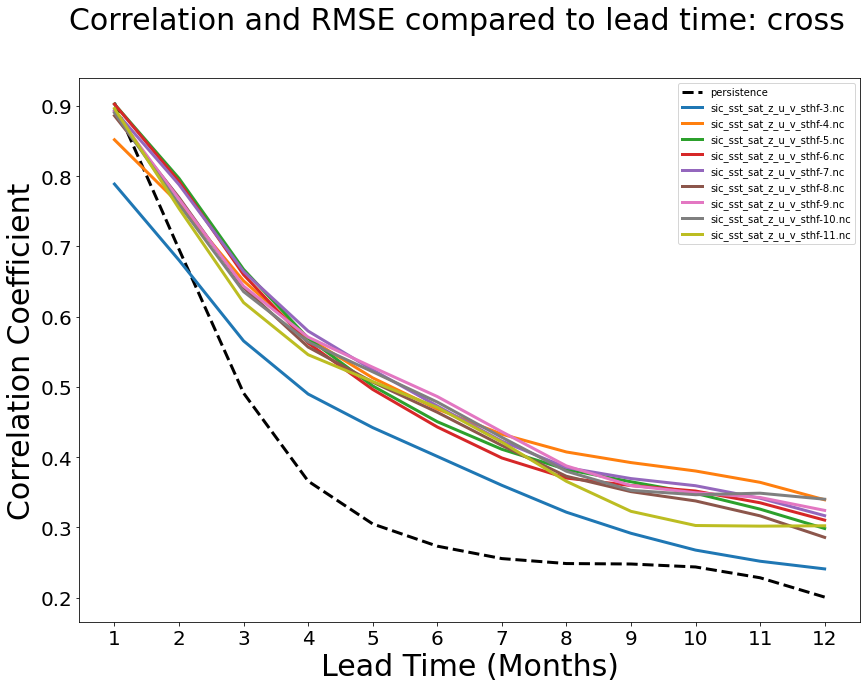

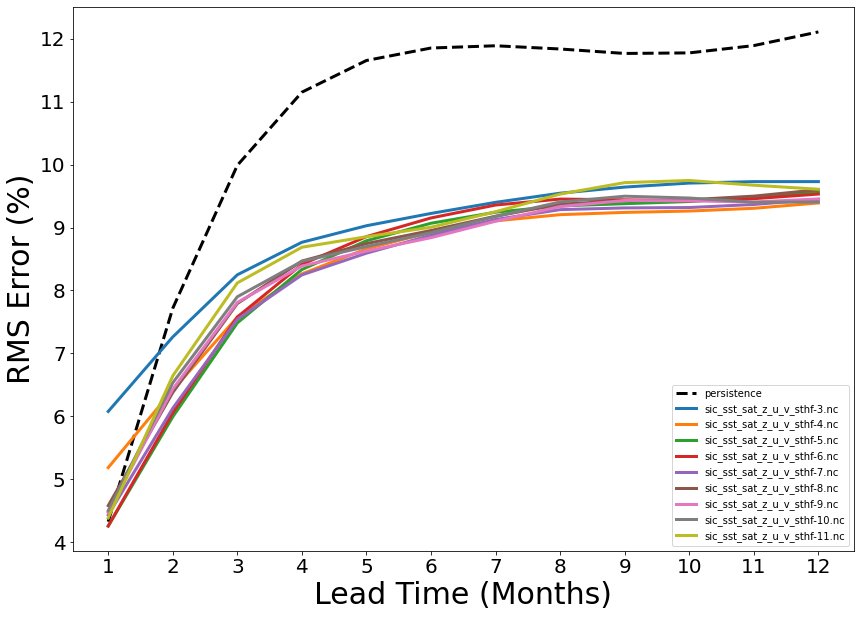

In [21]:
mode_comparison = ['sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-'+str(i)+'.nc' for i in range(3, 12)]
new_plt = leadtime_plot('cross', mode_comparison, dp1_region)

__Conclusions__:
- 9 modes looks good for sic_sst_sat_sthf.
- keep runnin it tho.

## Comparing my old poster plots with the new plots

In [55]:
new_poster_files = ['sic-2-11.nc',
               'sic_sst-2*1-11.nc',
               'sic_sat_z_u_v_sthf-2*1*0.2*0.2*0.2*1-11.nc',
               'sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc']
comparing = ['sic-2-11.nc',
               'sic_sst-2*1-11.nc',
               'sic_sat_z_u_v_sthf-2*1*0.2*0.2*0.2*1-11.nc',
               'sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc',
                   'sic_2_11.nc',
               'sic_sst_2*1_11.nc',
               'sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc',
               'sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc']

# of zz matrices to plot: 4
Loaded in sic-2-11.nc
Loaded in sic_sst-2*1-11.nc
Loaded in sic_sat_z_u_v_sthf-2*1*0.2*0.2*0.2*1-11.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc


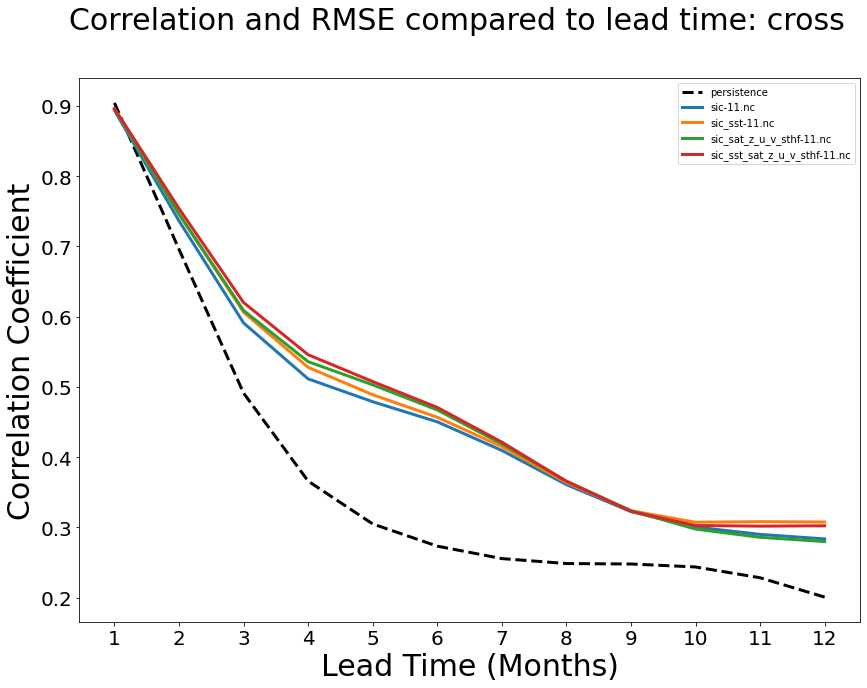

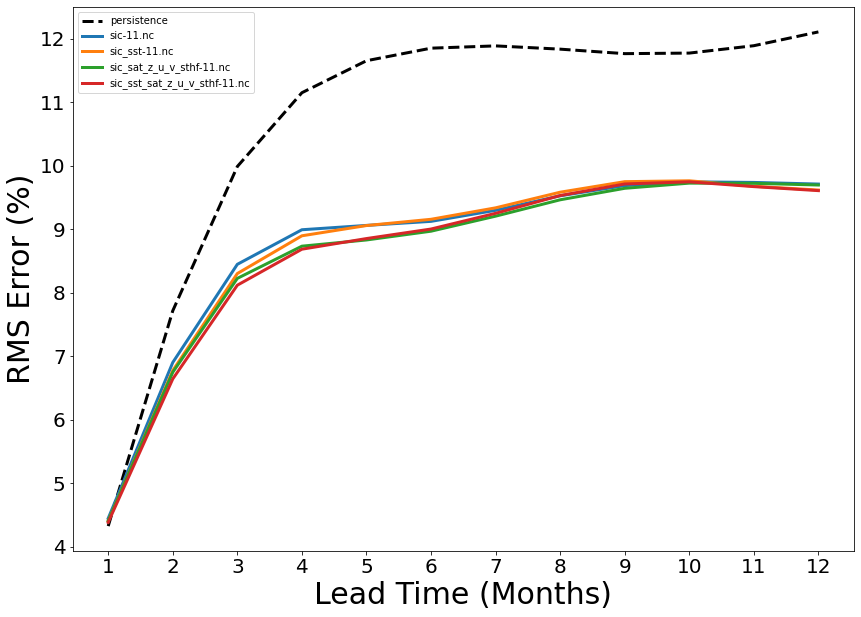

TypeError: cannot unpack non-iterable NoneType object

In [53]:
f, mt, z, r, ac, ar, pc, pr = leadtime_plot('cross', new_poster_files, dp1_region)

# of zz matrices to plot: 8
Loaded in sic-2-11.nc
Loaded in sic_sst-2*1-11.nc
Loaded in sic_sat_z_u_v_sthf-2*1*0.2*0.2*0.2*1-11.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc
Loaded in sic_2_11.nc
Loaded in sic_sst_2*1_11.nc
Loaded in sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
Loaded in sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


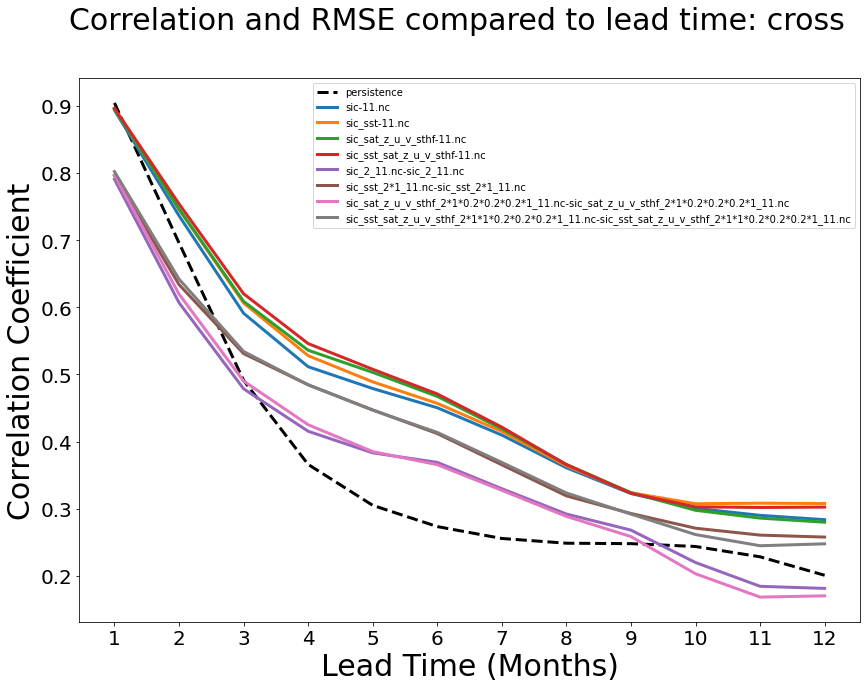

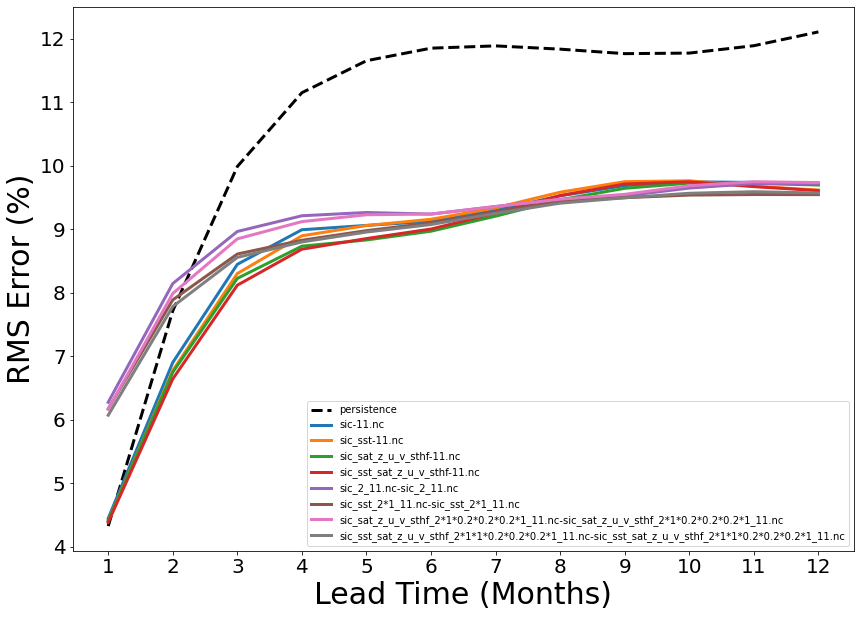

In [56]:
leadtime_plot('cross', comparing, dp1_region)

# of zz matrices to plot: 8
Loaded in sic-2-11.nc
Loaded in sic_sst-2*1-11.nc
Loaded in sic_sat_z_u_v_sthf-2*1*0.2*0.2*0.2*1-11.nc
Loaded in sic_sst_sat_z_u_v_sthf-2*1*1*0.2*0.2*0.2*1-11.nc
Loaded in sic_2_11.nc
Loaded in sic_sst_2*1_11.nc
Loaded in sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
Loaded in sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


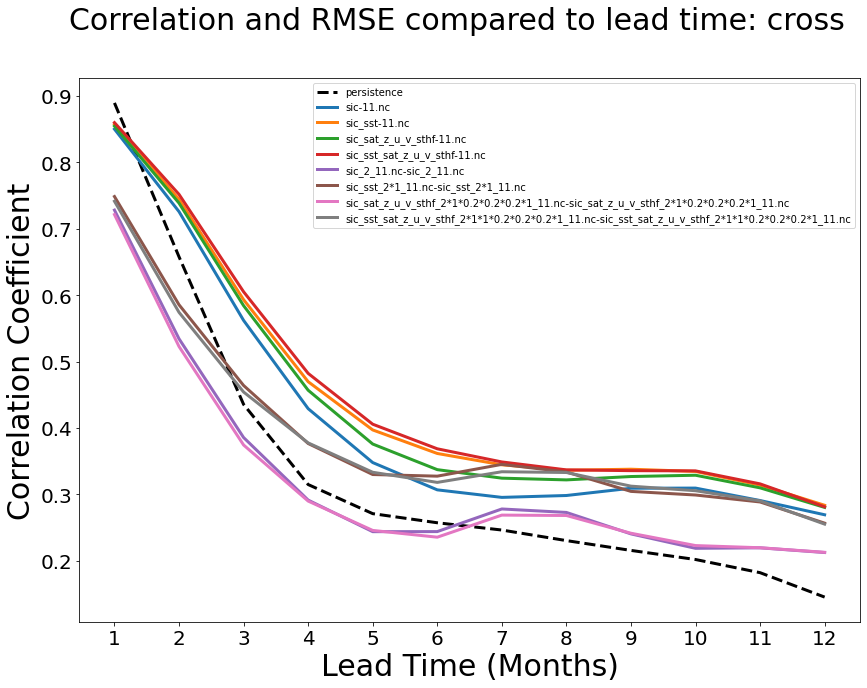

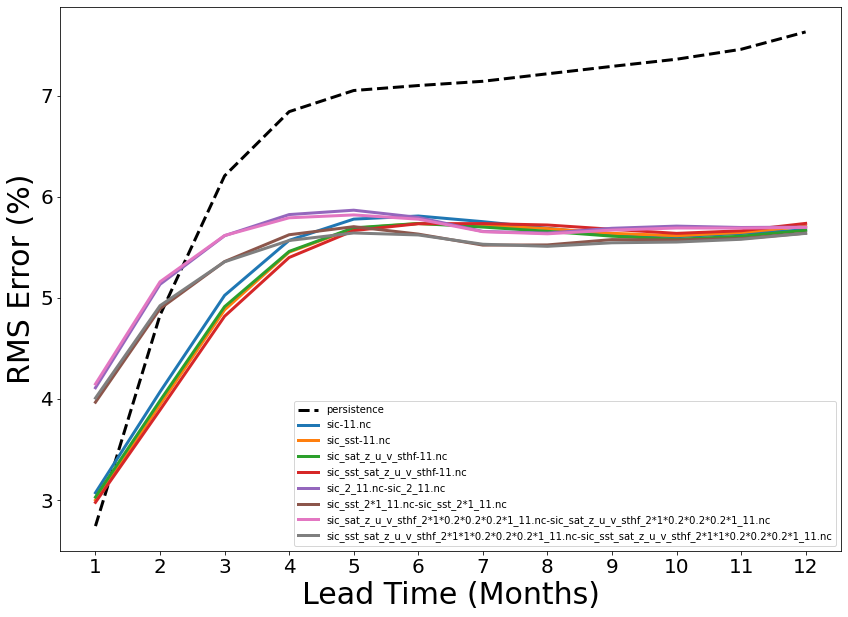

In [60]:
leadtime_plot('cross', comparing, e2_region)

## THIS IS OLD SHIT BELOW, COMPARING OUR OLD MODEL STUFF WITH CURRENT PERSISTENCE WHICH IS WHY IT LOOKS WEIRD. OMG I PANICKED. JESUS CHRIST.

# of zz matrices to plot: 4
Loaded in sic_2_11.nc
Loaded in sic_sst_2*1_11.nc
Loaded in sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
Loaded in sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


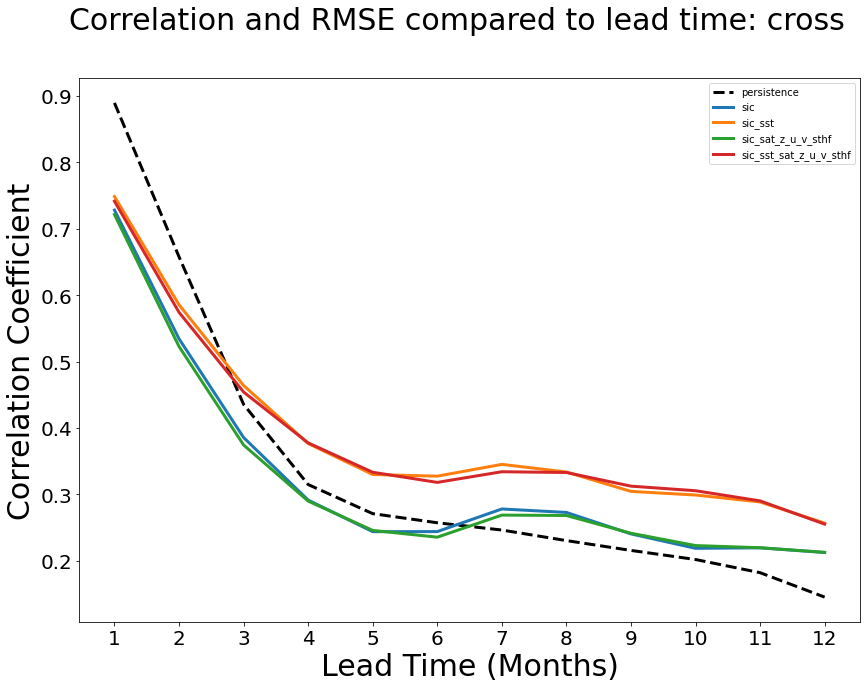

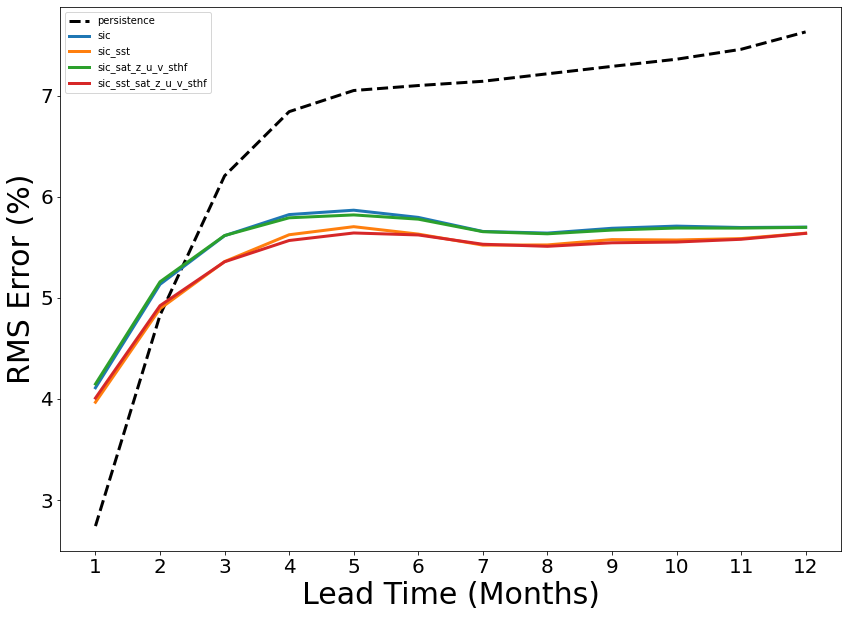

TypeError: cannot unpack non-iterable NoneType object

In [59]:
f, c, r, t, z, pc, pr = leadtime_plot('cross', diff_looks, e2_region, corr_legend)

# of zz matrices to plot: 4
Loaded in sic_2_11.nc
Loaded in sic_sst_2*1_11.nc
Loaded in sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
Loaded in sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


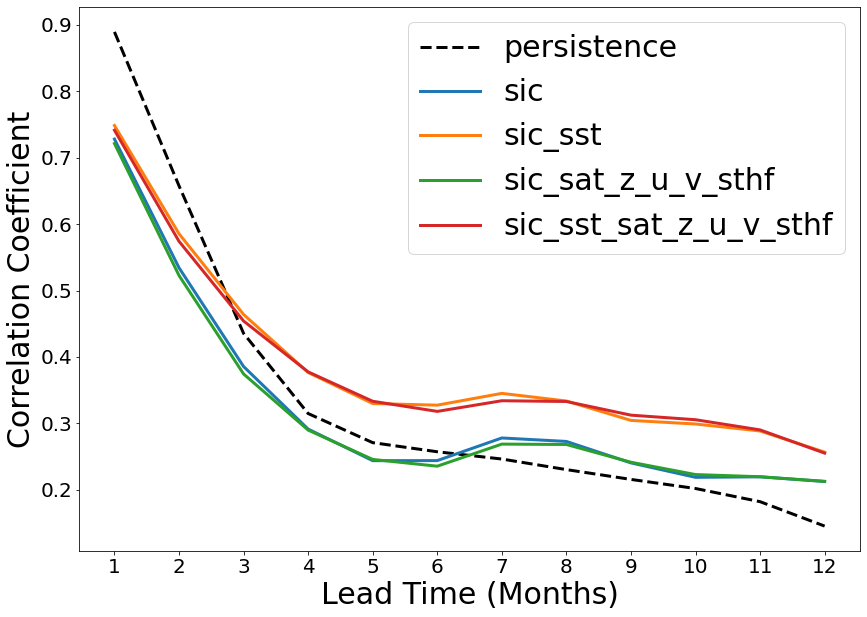

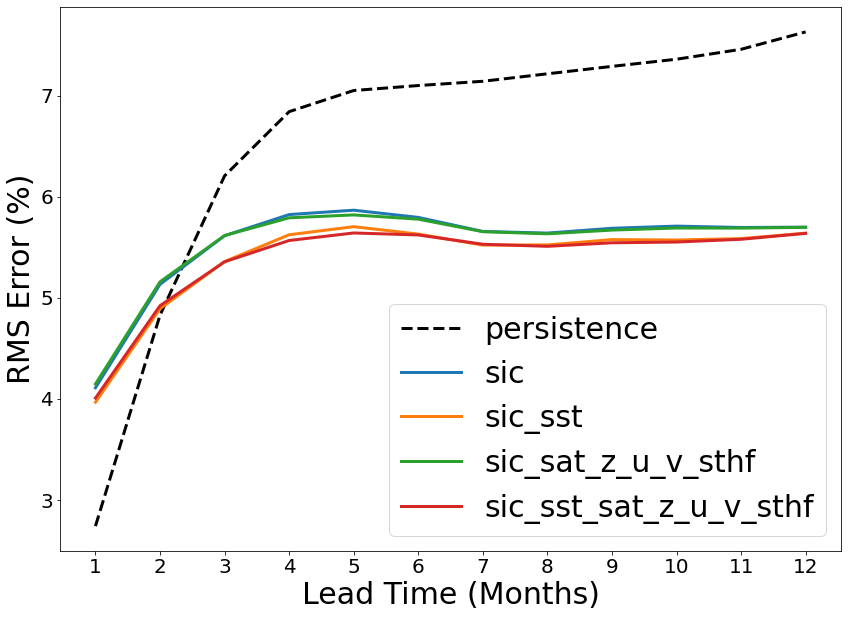

In [30]:
f, c, r, t, z, pc, pr = leadtime_plot('cross', diff_looks, e2_region, corr_legend)

In [58]:
diff_looks = ['sic_2_11.nc',
               'sic_sst_2*1_11.nc',
               'sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc',
               'sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc']
final_comps = ['sic_2_11.nc',
               'sic_sst_2*1_11.nc',
               'sic_sst_sat_2*1*1_11.nc',
               'sic_sst_sat_sthf_2*1*1*1_11.nc',
               'sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc',
               'sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc']
corr_legend = ['sic',
               'sic_sst',
               'sic_sat_z_u_v_sthf',
               'sic_sst_sat_z_u_v_sthf']

# DAWG. EVERYTHING BELOW IS OLD AND KINDA OUTDATED. SOME GRAPHS HELPFUL THO. RECREATE LATER WHEN U HAVE IT ALL.

### corr/rmse plots for Different Variables

In [10]:
## LOOP THRU ALL FILENAMES W/ MODE=mode.
# Trying to figure out which combination of VARS is the best.



# have to update w/ persistence.



def leadtime_plot_vars(matrix_type, mode, region):
    sic_obsr = hcast_or_cross(matrix_type, region)
    
    # Choose the names of the files you are comparing.
    zz_files = glob.glob("*_" + str(mode) + ".nc")
    zz_files.sort()
    flen = len(zz_files)
    print("# of zz matrices: " + str(flen))
    print(zz_files)

    # Calculate the corrs and rmses.
    avg_corrs = np.zeros([flen, 12])
    avg_rmse = np.zeros([flen, 12])
    for i in range(flen):
        # Load in the hindcast w/ [modes] # of modes.
        sic_zz =xr.open_dataset(zz_files[i]).__xarray_dataarray_variable__
        sic_zzr = sic_zz.where(region).where(validpoints)
        for lead in range(1, 13):
            avg_corrs[i, lead-1] = xr.corr(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim').mean().data
            avg_rmse[i, lead-1] = xs.rmse(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim', skipna=True).mean().data   
    
    # Plot the avg_corrs, avg_rmse matrices.
    plot_corrs_rmses(flen, avg_corrs, avg_rmse, matrix_type, zz_files)
    return flen, avg_corrs, avg_rmse, matrix_type, zz_files

### Comparing correlation, rmse of diff modes:

In [11]:
# Parameter, increment the # of modes by the paremeter step
#Trying to figure out which amount of MODES is the best.




# have to update w/ persistence.



def leadtime_plot_modes(matrix_type, min_mode, max_mode, step, region):
    sic_obsr = hcast_or_cross(matrix_type, region)
    
    # Initialize the matrices where we store our corrs and rmse's
    flen = int((max_mode-min_mode)/step) + 1
    avg_corrs = np.zeros([flen , 12])
    avg_rmse = np.zeros([flen, 12])
    
    zz_files = []
    for i in range(flen):
        modes = min_mode + i*step 
        # Load in the hindcast w/ [modes] # of modes.
        #___ if should be f_name here instead of f_start. later. ******CHANGEEEEEE.
        zz_name = '/d6/bxw2101/model_files/' + matrix_type + '_output/'+f_name+'_'+ str(modes) + '.nc'
        zz_files.append(f_name+'_'+ str(modes))
        #___
        print(f_name+'_'+ str(modes))
        sic_zz =xr.open_dataset(zz_name).__xarray_dataarray_variable__
        sic_zzr = sic_zz.where(region).where(validpoints)
        for lead in range(1, 13):
            avg_corrs[i, lead-1] = xr.corr(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim').mean().data
            avg_rmse[i, lead-1] = xs.rmse(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim', skipna=True).mean().data
    
    plot_corrs_rmses(flen, avg_corrs, avg_rmse, matrix_type, zz_files)
    return flen, avg_corrs, avg_rmse, matrix_type, zz_files

In [12]:
# Parameter, increment the # of modes by the paremeter step
#Trying to figure out which amount of MODES is the best.
def leadtime_plot_modes_rindex(matrix_type, min_mode, max_mode, step, region, clegend = []):
    #weighted mean of the observed region.
    sic_obsr = hcast_or_cross(matrix_type, region)
    sic_obsr_weights = np.cos(np.deg2rad(sic_obsr.y))
    sic_obsr_wghtd = sic_obsr * sic_obsr_weights
    sic_region_mean = sic_obsr_wghtd.mean(dim=['x', 'y'])
    
    # calculate persistence: just an acf.
    persistence_c = np.zeros(12)
    persistence_r = np.zeros(12)
    for lag in range(1,13):
        persistence_c[lag-1] = xr.corr(sic_region_mean.shift(tdim=-lag), sic_region_mean, dim='tdim').data
        persistence_r[lag-1] = xs.rmse(sic_region_mean.shift(tdim=-lag), sic_region_mean, dim='tdim', skipna=True).data
    
    flen = int((max_mode-min_mode)/step) + 1
    avg_corrs = np.zeros([flen , 12])
    avg_rmse = np.zeros([flen, 12])
    
    zz_files = []
    for i in range(flen):
        modes = min_mode + i*step 
        zz_name = '/d6/bxw2101/model_files/' + matrix_type + '_output/'+f_name+'_'+ str(modes) + '.nc'
        zz_files.append(f_name+'_'+ str(modes))
        print(f_name+'_'+ str(modes))
        
        #weighted mean of the cross validation zz matrix' region.
        sic_zz =xr.open_dataset(zz_name).__xarray_dataarray_variable__
        sic_zzr = sic_zz.where(region).where(validpoints)
        sic_zzr_wghtd = sic_zzr * sic_obsr_weights
        sic_zzr_mean = sic_zzr_wghtd.mean(dim=['x','y'])
        
        for lead in range(1, 13):
            avg_corrs[i, lead-1] = xr.corr(sic_region_mean, sic_zzr_mean.sel(lead=lead)).data
            avg_rmse[i, lead-1] = xs.rmse(sic_region_mean, sic_zzr_mean.sel(lead=lead), dim='tdim', skipna=True).data
    
    plot_corrs_rmses(flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r)
    return flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r

### Just looking at one single hindcast matrix's correlation, rmse.

In [26]:
def leadtime_plot_single(matrix_type, mode, region):
    sic_obsr = hcast_or_cross(matrix_type, region)
    avg_corrs = np.zeros([1, 12])
    avg_rmse = np.zeros([1, 12])
    sic_zz =xr.open_dataset('/d6/bxw2101/model_files/'+matrix_type+'_output/'+f_name+'_'+ str(mode) + '.nc').__xarray_dataarray_variable__
    sic_zzr = sic_zz.where(region).where(validpoints)
    for lead in range(1, 13):
            avg_corrs[0, lead-1] = xr.corr(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim').mean().data
            avg_rmse[0, lead-1] = xs.rmse(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim', skipna=True).mean().data
    flen=1
    zz_files=[f_name+'_'+ str(mode) + '.nc']
    plot_corrs_rmses(flen, avg_corrs, avg_rmse, matrix_type, zz_files)
    return avg_corrs, avg_rmse

In [28]:
leadtime_plot_single('hcast',11,dp1_region)

TypeError: plot_corrs_rmses() missing 2 required positional arguments: 'persistence_c' and 'persistence_r'

### (INProgress) Compare diff weights of models w/ the same variables and modes.

In [14]:
## set vars&modes, just modifying weights.
def leadtime_plot_weights(f_start, mode, region):
    # Get all files with the same # of modes.
    os.chdir("/d6/bxw2101/model_files/hcast_output")
    hcast_files = glob.glob(f_start + "*_" + str(mode) + ".nc")
    hcast_files.sort()
    flen = len(hcast_files)
    print("# of hcast matrices: " + str(flen))
    print(hcast_files)

    avg_corrs = np.zeros([flen, 12])
    avg_rmse = np.zeros([flen, 12])
    xticks = np.arange(1, 13)
    
    sic_obsr = sic_obs.where(region)
          
          
    for i in range(flen):
        # Load in the hindcast w/ [modes] # of modes.
        sic_hcast =xr.open_dataset(hcast_files[i]).__xarray_dataarray_variable__
        sic_hcastr = sic_hcast.where(region).where(validpoints)
        for lead in range(1, 13):
            avg_corrs[i, lead-1] = xr.corr(sic_obsr, sic_hcastr.sel(lead=lead), dim='tdim').mean().data
            avg_rmse[i, lead-1] = xs.rmse(sic_obsr, sic_hcastr.sel(lead=lead), dim='tdim', skipna=True).mean().data
            
    fig = plt.figure(figsize=(20,14))
    for i in range(flen):
        plt.plot(xticks, avg_corrs[i])
    plt.xticks(xticks);
    plt.title('1980-2021')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Lead Time (Months)')
    plt.legend(hcast_files)
    plt.show()

    fig = plt.figure(figsize=(20,14))
    for i in range(flen):
        plt.plot(xticks, avg_rmse[i]*100)
    plt.xticks(xticks);
    plt.title('1980-2021')
    plt.ylabel('RMS Error (%)')
    plt.xlabel('Lead Time (Months)')
    plt.legend(hcast_files)
    plt.show()
    
    return avg_corrs, avg_rmse

In [15]:
# Manually enter the filenames as a list.
def leadtime_plot_fnames(matrix_type, zz_files, region):
    sic_obsr = hcast_or_cross(matrix_type, region)
    flen = len(zz_files)
    print("# of zz matrices: " + str(flen))
    print(zz_files)

    avg_corrs = np.zeros([flen, 12])
    avg_rmse = np.zeros([flen, 12])
    for i in range(flen):
        # Load in the hindcast w/ [modes] # of modes.
        sic_zz =xr.open_dataset(zz_files[i]).__xarray_dataarray_variable__
        sic_zzr = sic_zz.where(region).where(validpoints)
        for lead in range(1, 13):
            avg_corrs[i, lead-1] = xr.corr(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim').mean().data
            avg_rmse[i, lead-1] = xs.rmse(sic_obsr, sic_zzr.sel(lead=lead), dim='tdim', skipna=True).mean().data
            
    plot_corrs_rmses(flen, avg_corrs, avg_rmse, matrix_type, zz_files)
    return flen, avg_corrs, avg_rmse, matrix_type, zz_files

In [31]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, dp1_region, corr_legend)

NameError: name 'diff_looks' is not defined

### Below show correlations, to evaluate model effectiveness.

## Comparing different MODE numbers for now, over regions' index:

sic_sst_sat_sthf_2*1*1*0.5_3
sic_sst_sat_sthf_2*1*1*0.5_6
sic_sst_sat_sthf_2*1*1*0.5_9
sic_sst_sat_sthf_2*1*1*0.5_12
sic_sst_sat_sthf_2*1*1*0.5_15
sic_sst_sat_sthf_2*1*1*0.5_18
sic_sst_sat_sthf_2*1*1*0.5_21
sic_sst_sat_sthf_2*1*1*0.5_24
sic_sst_sat_sthf_2*1*1*0.5_27
sic_sst_sat_sthf_2*1*1*0.5_30


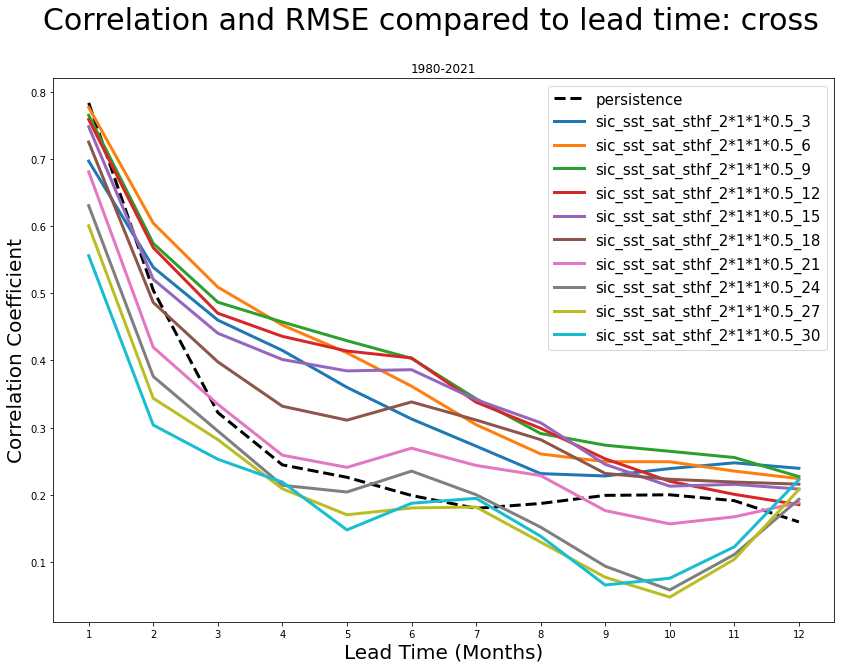

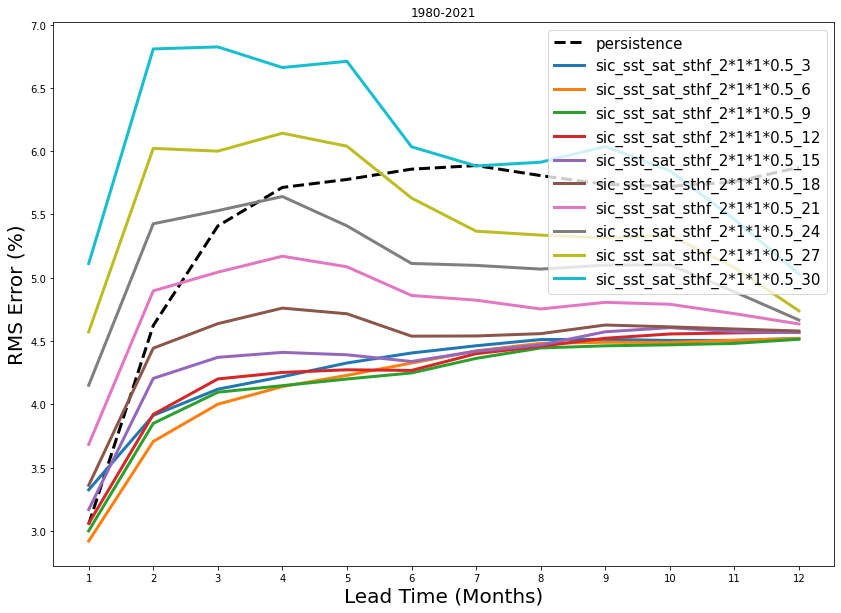

In [54]:
flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r = leadtime_plot_modes_rindex('cross', 3, 30, 3, dp1_region)

sic_sst_sat_sthf_3
sic_sst_sat_sthf_6
sic_sst_sat_sthf_9
sic_sst_sat_sthf_12
sic_sst_sat_sthf_15
sic_sst_sat_sthf_18
sic_sst_sat_sthf_21
sic_sst_sat_sthf_24
sic_sst_sat_sthf_27
sic_sst_sat_sthf_30


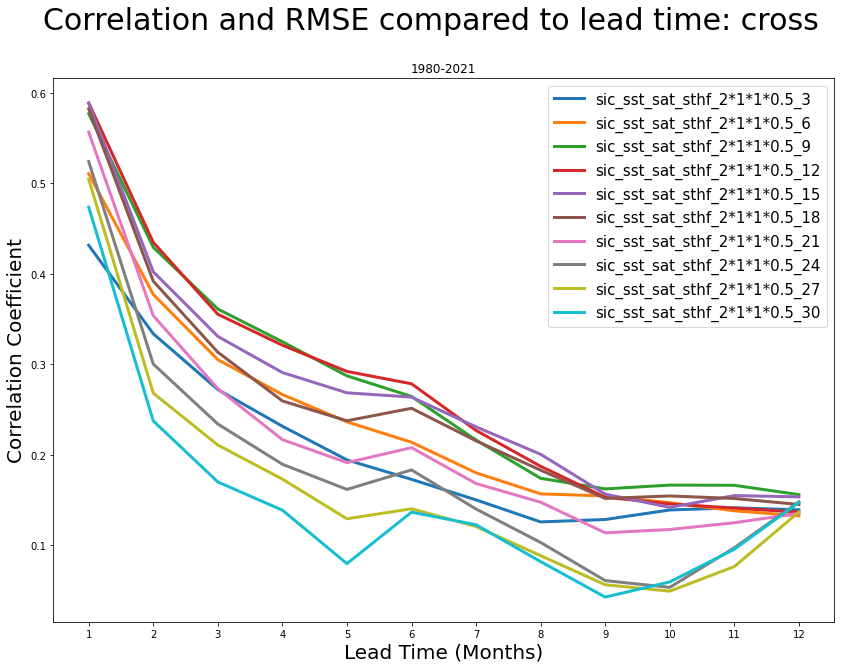

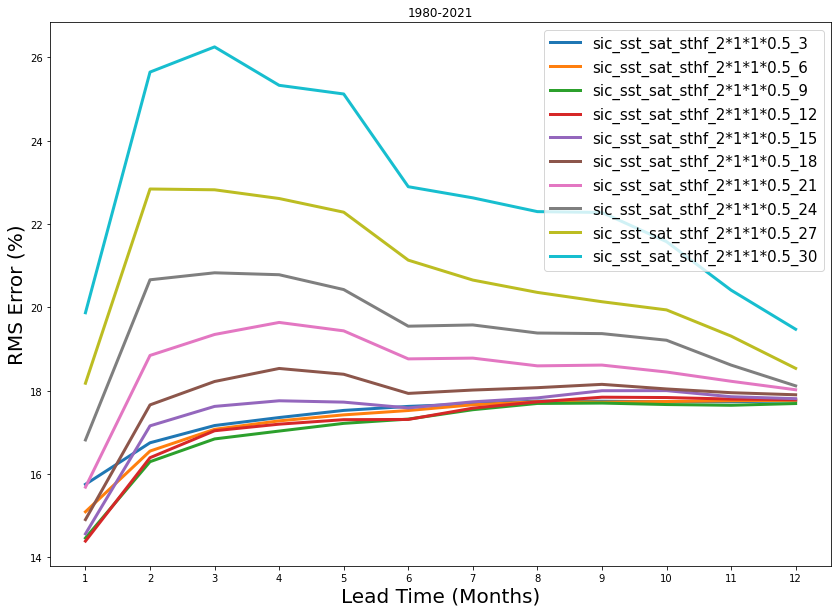

In [37]:
cflen, cdp1_avg_corrs, cdp1_avg_rmse, cmatrix_type, czz_files = leadtime_plot_modes('cross', 3, 30, dp1_region)

sic_sst_sat_sthf_2*1*1*0.5_9
sic_sst_sat_sthf_2*1*1*0.5_10
sic_sst_sat_sthf_2*1*1*0.5_11
sic_sst_sat_sthf_2*1*1*0.5_12


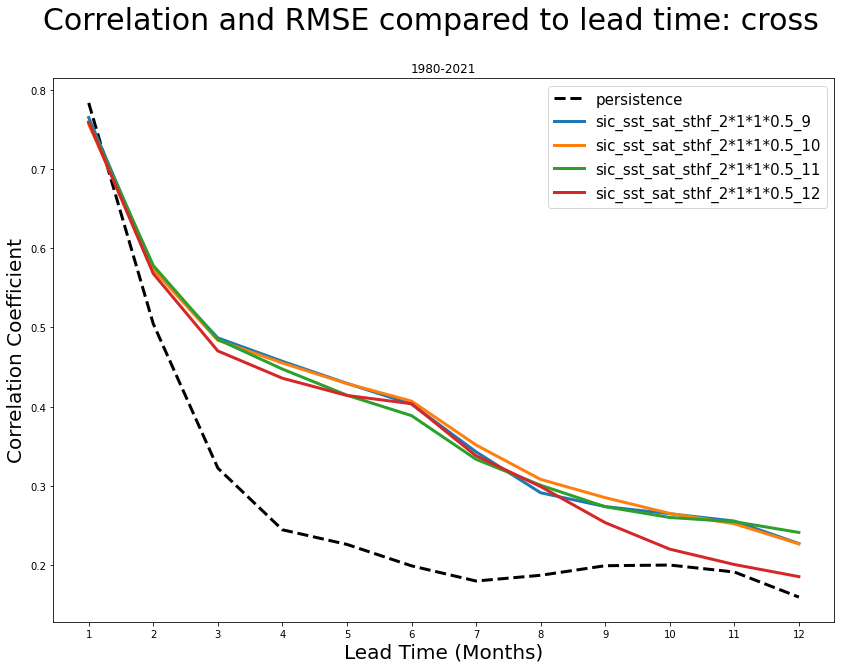

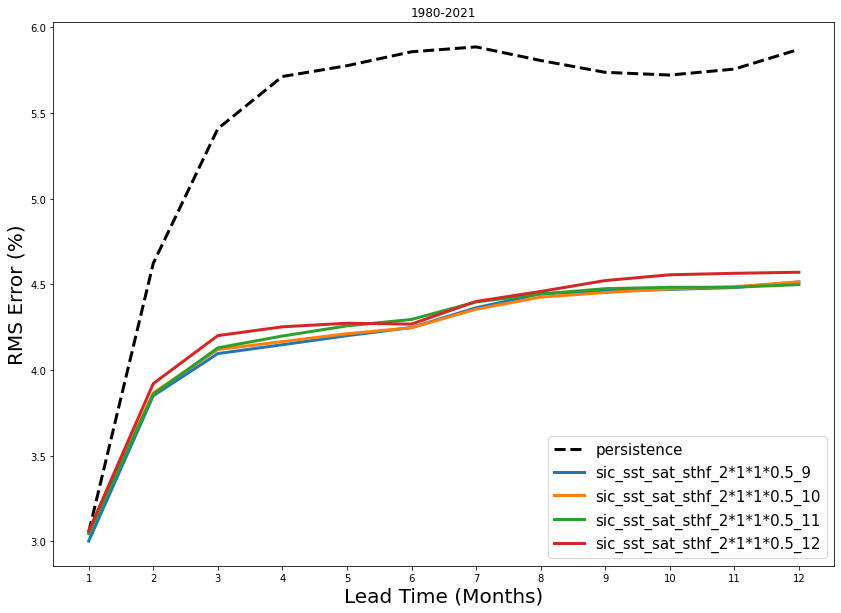

In [55]:
flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r = leadtime_plot_modes_rindex('cross', 9, 12, 1, dp1_region)

# of zz matrices: 5
['sic_sst_sat_sthf_2*1*1*1_9.nc', 'sic_sst_sat_sthf_2*1*1*1_10.nc', 'sic_sst_sat_sthf_2*1*1*1_11.nc', 'sic_sst_sat_sthf_2*1*1*1_12.nc', 'sic_sst_sat_sthf_2*1*1*1_13.nc']
sic_sst_sat_sthf_2*1*1*1_9.nc
sic_sst_sat_sthf_2*1*1*1_10.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_12.nc
sic_sst_sat_sthf_2*1*1*1_13.nc


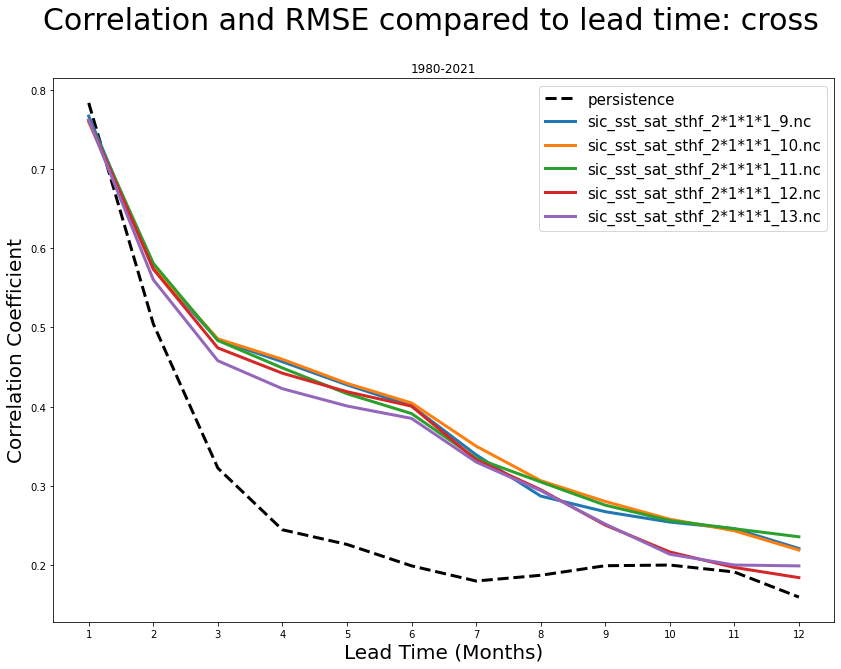

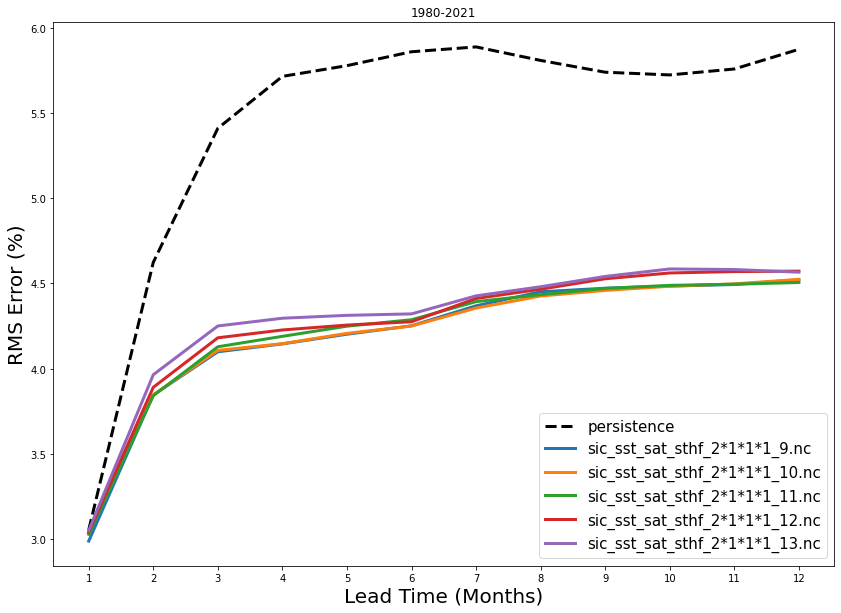

(5,
 array([[0.76670706, 0.57402879, 0.48427665, 0.45666301, 0.4274958 ,
         0.40084371, 0.3391894 , 0.28708867, 0.26736055, 0.25424665,
         0.24595338, 0.22088639],
        [0.75904063, 0.57673126, 0.48553918, 0.4597442 , 0.42935861,
         0.4046046 , 0.35012375, 0.30659076, 0.28028825, 0.2578321 ,
         0.24330625, 0.21897236],
        [0.761833  , 0.58096466, 0.48348295, 0.44882768, 0.416276  ,
         0.3912365 , 0.33480062, 0.30495928, 0.2756042 , 0.25615593,
         0.24582924, 0.23566616],
        [0.76148151, 0.57378813, 0.47407883, 0.44216721, 0.41881995,
         0.40060863, 0.33280386, 0.29512335, 0.25044937, 0.21653404,
         0.19698169, 0.18410532],
        [0.76159808, 0.56026398, 0.45790292, 0.42261163, 0.40077373,
         0.38511015, 0.33013372, 0.29396634, 0.2517747 , 0.21367786,
         0.20003728, 0.19891858]]),
 array([[0.02988179, 0.0384518 , 0.0409825 , 0.04144475, 0.04201295,
         0.04250863, 0.04368098, 0.04450262, 0.0447109 , 0.044838

In [56]:
brotha = ['sic_sst_sat_sthf_2*1*1*1_9.nc',
          'sic_sst_sat_sthf_2*1*1*1_10.nc',
          'sic_sst_sat_sthf_2*1*1*1_11.nc',
          'sic_sst_sat_sthf_2*1*1*1_12.nc',
          'sic_sst_sat_sthf_2*1*1*1_13.nc',
         ]
flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r = leadtime_plot_fnames_rindex('cross', brotha, dp1_region)

# of zz matrices: 5
sic_sst_sat_sthf_2*1*1*1_9.nc
sic_sst_sat_sthf_2*1*1*1_10.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_12.nc
sic_sst_sat_sthf_2*1*1*1_13.nc


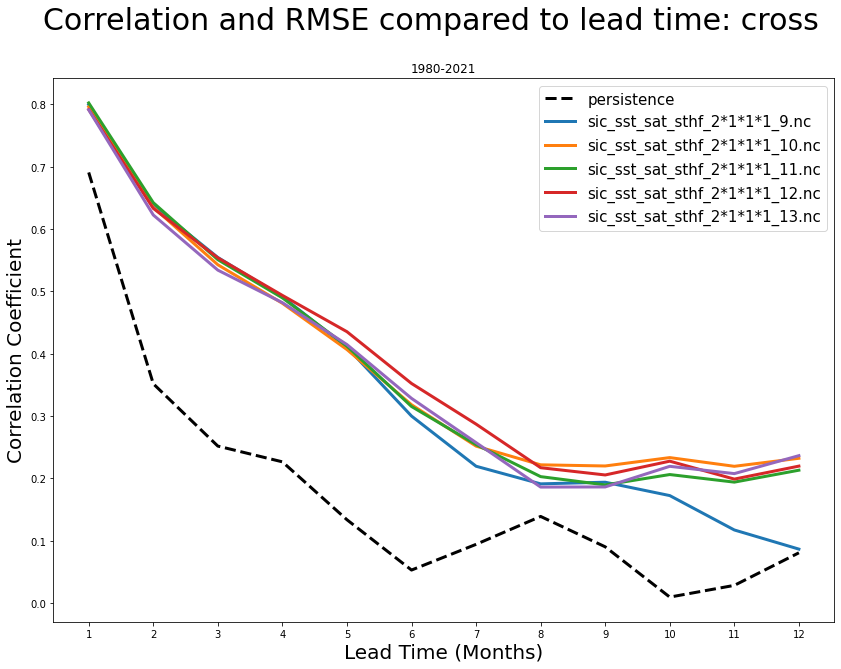

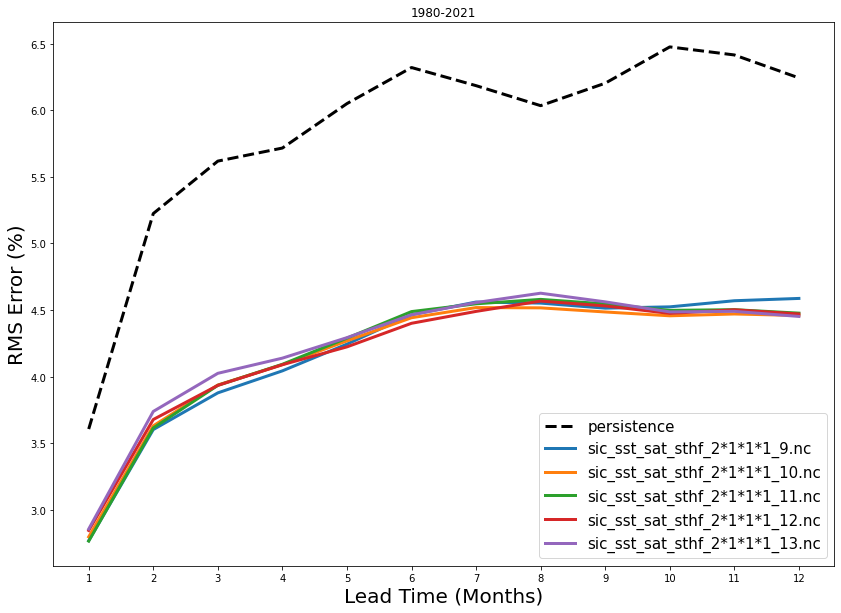

(5,
 array([[0.79941764, 0.63767596, 0.55434526, 0.49129891, 0.41019388,
         0.30000795, 0.21954532, 0.19129431, 0.19393309, 0.17248935,
         0.11734608, 0.0866628 ],
        [0.79588537, 0.63471561, 0.54261149, 0.4808359 , 0.40663529,
         0.31812791, 0.25180189, 0.22181735, 0.21997652, 0.23340915,
         0.21944008, 0.23228692],
        [0.80213779, 0.64219592, 0.55075771, 0.48952896, 0.41211492,
         0.31534375, 0.25421715, 0.2028952 , 0.18961826, 0.206233  ,
         0.19405906, 0.21318942],
        [0.79158004, 0.63305348, 0.55372123, 0.49349476, 0.43525636,
         0.35226024, 0.2870884 , 0.2171936 , 0.20555706, 0.22767366,
         0.19893995, 0.21974619],
        [0.79096901, 0.62242948, 0.5340149 , 0.48184055, 0.41463587,
         0.32837731, 0.25739225, 0.18613494, 0.18634749, 0.21941806,
         0.20773004, 0.23651318]]),
 array([[0.0276817 , 0.03602161, 0.03877682, 0.04042987, 0.04243628,
         0.04464602, 0.04559529, 0.04551462, 0.04513633, 0.045233

In [58]:
flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r = leadtime_plot_fnames_rindex('cross', brotha, dp2_region)

# of zz matrices: 5
sic_sst_sat_sthf_2*1*1*1_9.nc
sic_sst_sat_sthf_2*1*1*1_10.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_12.nc
sic_sst_sat_sthf_2*1*1*1_13.nc


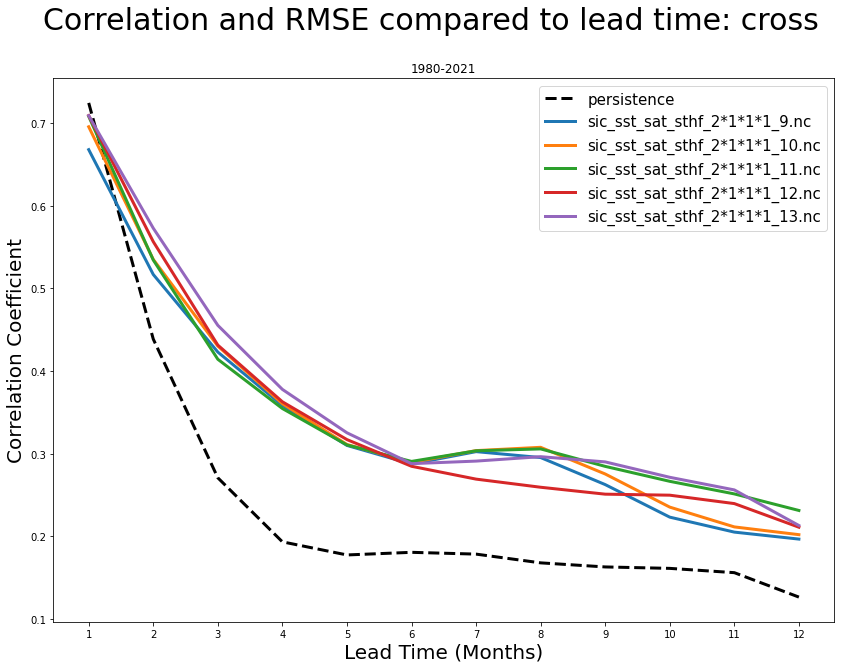

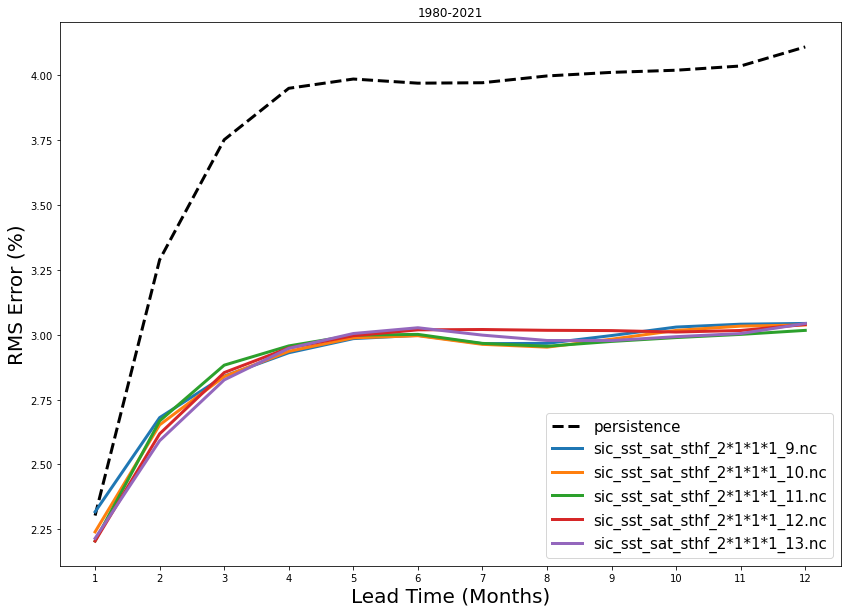

(5,
 array([[0.66795523, 0.51686258, 0.42296865, 0.35838935, 0.31000787,
         0.28745533, 0.30249179, 0.29532498, 0.2626026 , 0.22320386,
         0.20509371, 0.19664391],
        [0.69564066, 0.53512286, 0.43020045, 0.36052431, 0.31115246,
         0.28937644, 0.30372533, 0.30772163, 0.27543276, 0.23534431,
         0.21139239, 0.20200719],
        [0.70822225, 0.5343901 , 0.41425404, 0.35466314, 0.31056315,
         0.29066426, 0.30351279, 0.30579547, 0.28465446, 0.26655458,
         0.25132819, 0.23129425],
        [0.70924076, 0.55658727, 0.43140345, 0.36281508, 0.31706262,
         0.28476276, 0.26922153, 0.25938305, 0.25101168, 0.24978434,
         0.23961192, 0.21102676],
        [0.70910121, 0.5728967 , 0.4553298 , 0.37781322, 0.32528015,
         0.28793258, 0.29103762, 0.29638231, 0.29006615, 0.27143894,
         0.25617347, 0.21309398]]),
 array([[0.02317234, 0.02680446, 0.02840322, 0.02930579, 0.02985046,
         0.02997703, 0.02965557, 0.02966889, 0.02996939, 0.030296

In [59]:
flen, avg_corrs, avg_rmse, matrix_type, zz_files, persistence_c, persistence_r = leadtime_plot_fnames_rindex('cross', brotha, e1_region)

# of zz matrices: 6
['sic_sst_sat_sthf_2*1*1*0.5_10.nc', 'sic_sst_sat_sthf_2*1*1*0.5_11.nc', 'sic_sst_sat_sthf_2*1*1*0.5_12.nc', 'sic_sst_sat_sthf_2*1*1*0.5_13.nc', 'sic_sst_sat_sthf_2*1*1*0.5_14.nc', 'sic_sst_sat_sthf_2*1*1*0.5_15.nc']


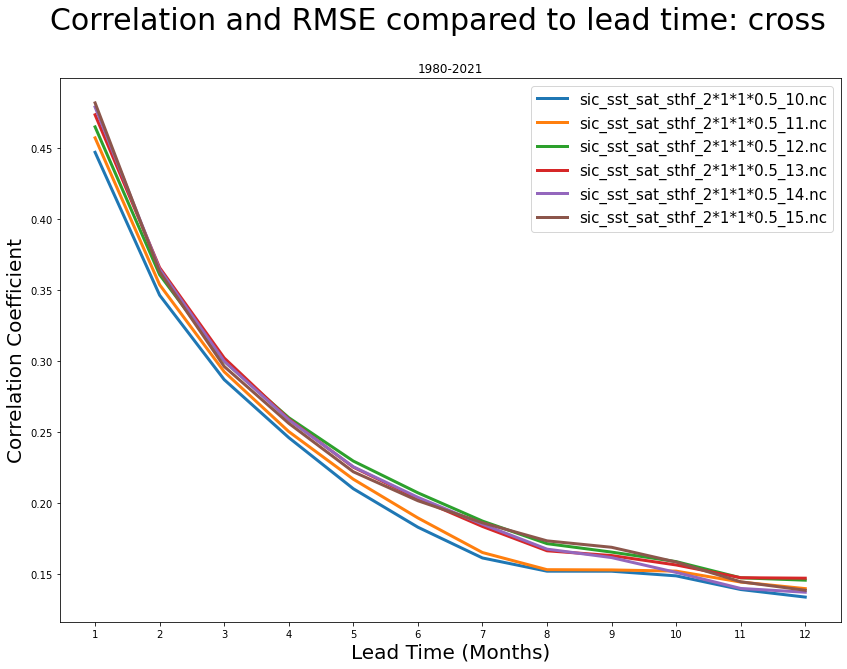

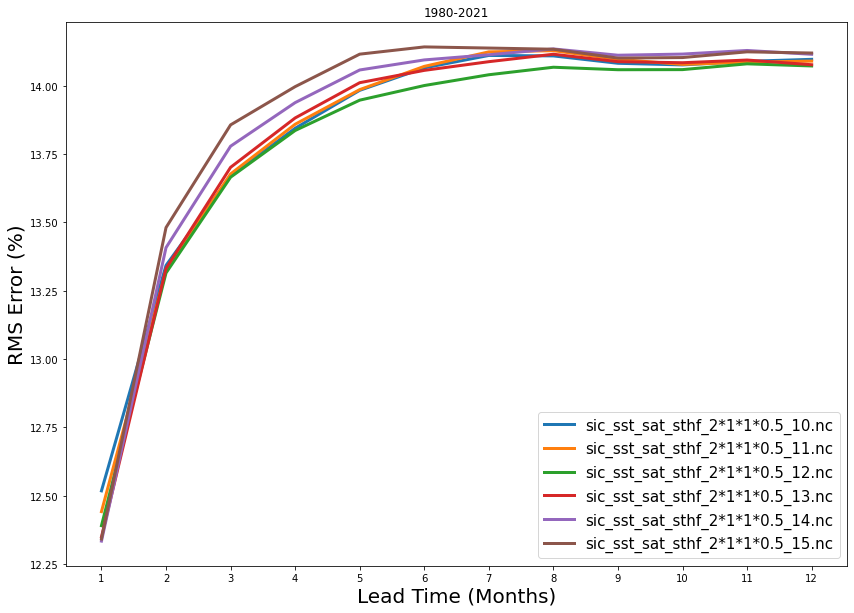

(6,
 array([[0.44709287, 0.34638569, 0.28685677, 0.2459936 , 0.20996898,
         0.18285219, 0.16117229, 0.15184952, 0.15182428, 0.14855667,
         0.13892302, 0.13359006],
        [0.45727906, 0.35373057, 0.29240595, 0.25024364, 0.21666779,
         0.18938519, 0.16500105, 0.1529152 , 0.15273664, 0.15189576,
         0.14419936, 0.13956284],
        [0.46501379, 0.36081228, 0.29987494, 0.26004799, 0.22945948,
         0.20708158, 0.18718258, 0.17125201, 0.16530159, 0.1586045 ,
         0.14718486, 0.145506  ],
        [0.47353985, 0.36578597, 0.30211432, 0.25906435, 0.22515575,
         0.20306815, 0.18336695, 0.16622883, 0.16286228, 0.15623933,
         0.1472518 , 0.14690986],
        [0.47904005, 0.36462149, 0.29987375, 0.25858689, 0.22543525,
         0.20389726, 0.18495301, 0.16739191, 0.1614403 , 0.15098804,
         0.1396786 , 0.13701603],
        [0.48191583, 0.36288131, 0.29614952, 0.25607418, 0.22190941,
         0.20150003, 0.18599396, 0.17322995, 0.16869514, 0.15831542

In [52]:
# Instead of taking an index, avg all corr's across the region (takes longer and shows worse results)
leadtime_plot_fnames('cross', brotha, entire_region)

sic_2_9
sic_2_10
sic_2_11
sic_2_12
sic_2_13
sic_2_14


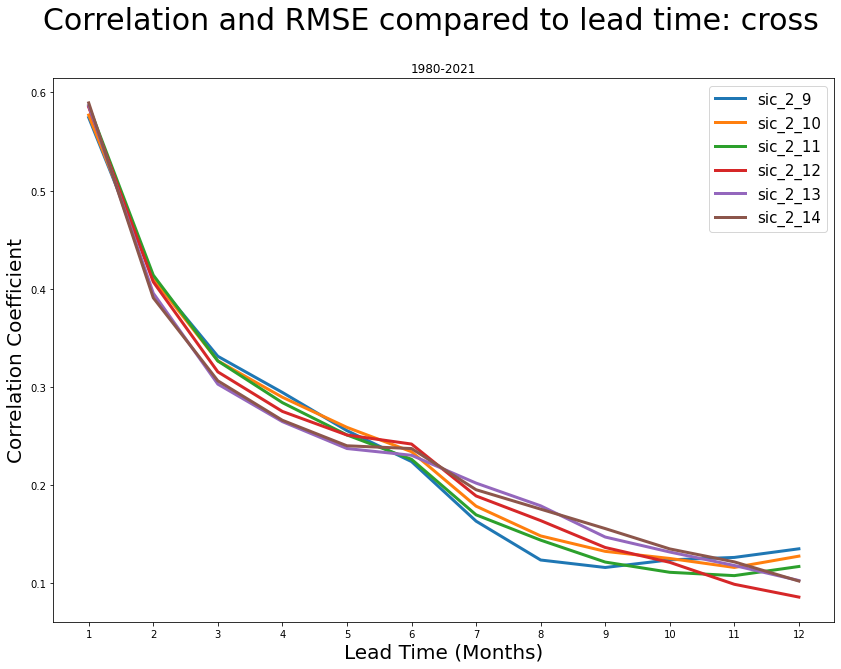

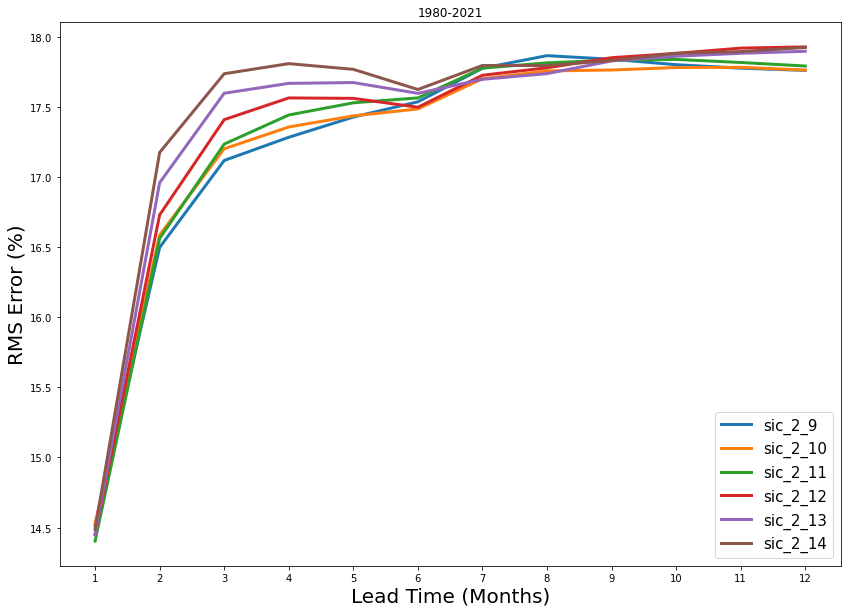

(6,
 array([[0.57436312, 0.41092373, 0.33130482, 0.29450479, 0.25561587,
         0.22412436, 0.16344731, 0.12387904, 0.1162725 , 0.12404604,
         0.12651387, 0.13529852],
        [0.57694024, 0.41043584, 0.32667699, 0.28961176, 0.25893137,
         0.23416648, 0.17870504, 0.14842626, 0.13269481, 0.12547091,
         0.116321  , 0.12781239],
        [0.58631648, 0.41397568, 0.32654608, 0.28412049, 0.25121584,
         0.22641864, 0.16987923, 0.14412018, 0.12179796, 0.11137645,
         0.107977  , 0.11728622],
        [0.58506436, 0.40709263, 0.31545219, 0.2751734 , 0.25115678,
         0.24195756, 0.18911395, 0.1640161 , 0.13662683, 0.12151266,
         0.09916177, 0.08612812],
        [0.58651749, 0.39557565, 0.30296383, 0.26480153, 0.2373957 ,
         0.2305148 , 0.20219847, 0.17906682, 0.14728537, 0.13202109,
         0.11829125, 0.10301323],
        [0.58931326, 0.39087902, 0.30636065, 0.26616639, 0.24019603,
         0.23737537, 0.19546187, 0.1756905 , 0.15589448, 0.13519261

In [189]:
leadtime_plot_modes('cross', 9, 14, 1, dp1_region)



sic_sst_2*1_10
sic_sst_2*1_11
sic_sst_2*1_12


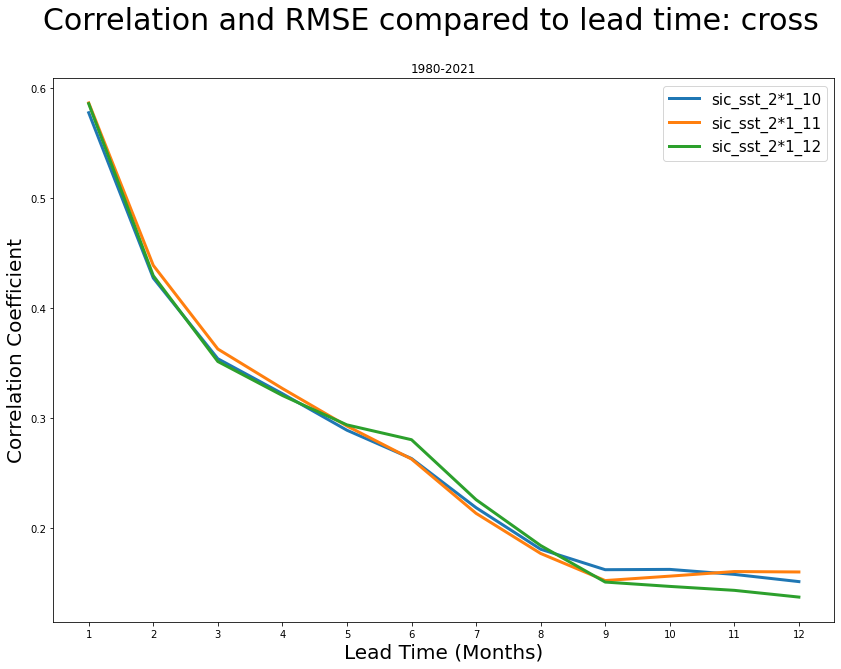

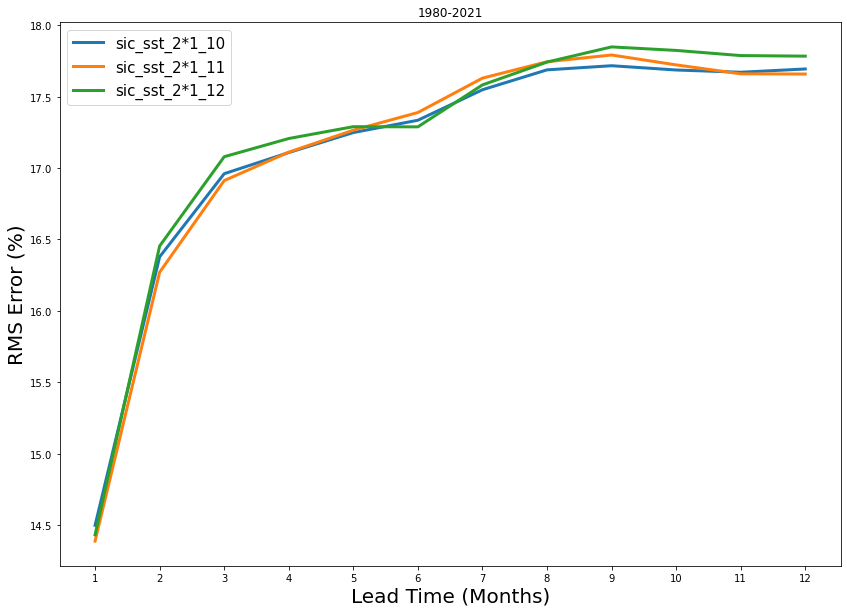

(3,
 array([[0.57780568, 0.42754891, 0.35420701, 0.32246831, 0.28922945,
         0.26350753, 0.21881697, 0.18105825, 0.16245102, 0.16273494,
         0.15819911, 0.15163568],
        [0.58673187, 0.43907417, 0.36303549, 0.32717438, 0.29306102,
         0.26301584, 0.21367501, 0.17720803, 0.15258297, 0.15660278,
         0.16077816, 0.16039236],
        [0.58603267, 0.42970981, 0.35169357, 0.32080927, 0.29408184,
         0.28060259, 0.22609369, 0.18443303, 0.15121831, 0.14727741,
         0.1436907 , 0.13756003]]),
 array([[0.14498623, 0.16378401, 0.16960429, 0.17108601, 0.17248524,
         0.1733477 , 0.17548336, 0.17687561, 0.1771652 , 0.1768657 ,
         0.17670821, 0.17693708],
        [0.14388339, 0.16270989, 0.16912304, 0.17111498, 0.17264982,
         0.17388818, 0.17629549, 0.17744255, 0.17791597, 0.17722253,
         0.1765984 , 0.17658325],
        [0.14432398, 0.1645431 , 0.17079399, 0.17206902, 0.17289655,
         0.17288559, 0.17582242, 0.17741978, 0.17848229, 0.178236

In [193]:
leadtime_plot_modes('cross', 10, 12, 1, dp1_region)


In [ ]:
dp1_avg_corrs, dp1_avg_rmse = leadtime_plot_vars(20, dp1_region)

In [ ]:
dp2_avg_corrs, dp2_avg_rmse = leadtime_plot_vars(20, dp2_region)

In [ ]:
e1_avg_corrs, e1_avg_rmse = leadtime_plot_vars(20, e1_region)

In [ ]:
flen, dp1_avg_corrs, dp1_avg_rmse, matrix_type, zz_files = leadtime_plot_modes('hcast', 2, 24, dp1_region)

# Looking at different regions, using the diff models of mode=12:

In [19]:
diff_looks = ['sic_2_11.nc',
               'sic_sst_2*1_11.nc',
               'sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc',
               'sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc']
final_comps = ['sic_2_11.nc',
               'sic_sst_2*1_11.nc',
               'sic_sst_sat_2*1*1_11.nc',
               'sic_sst_sat_sthf_2*1*1*1_11.nc',
               'sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc',
               'sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc']
corr_legend = ['sic',
               'sic_sst',
               'sic_sat_z_u_v_sthf',
               'sic_sst_sat_z_u_v_sthf']

# of zz matrices: 6
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sst_sat_2*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


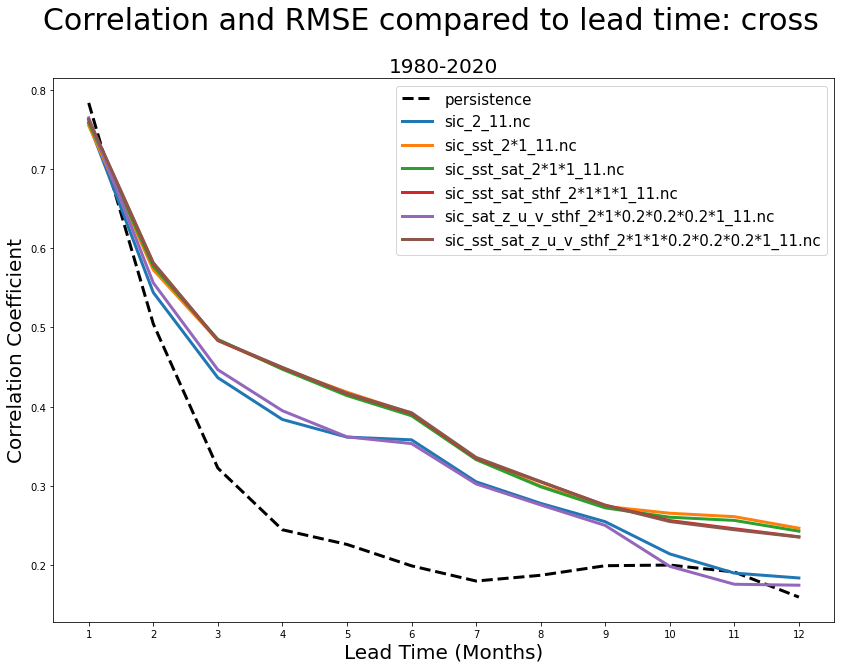

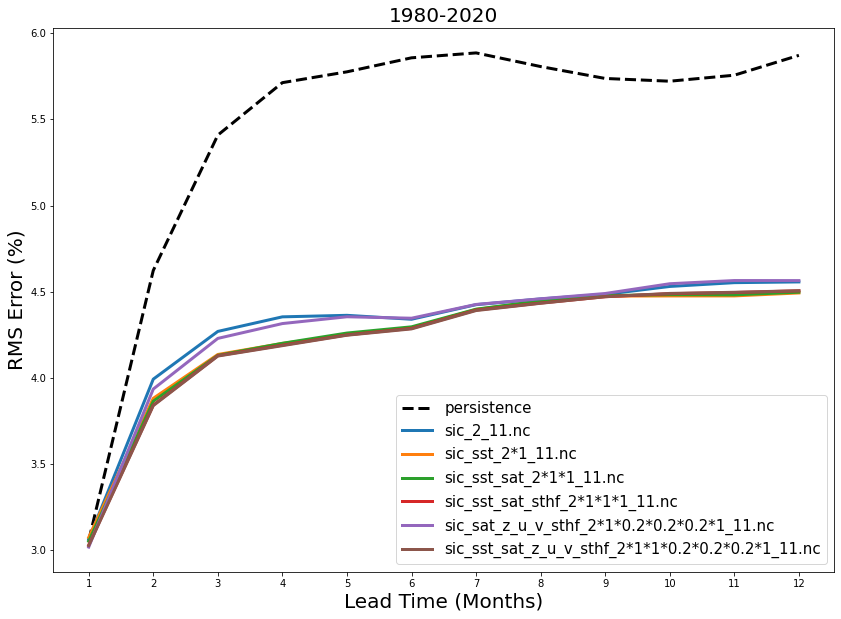

In [66]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', final_comps, dp1_region)

# of zz matrices: 6
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sst_sat_2*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


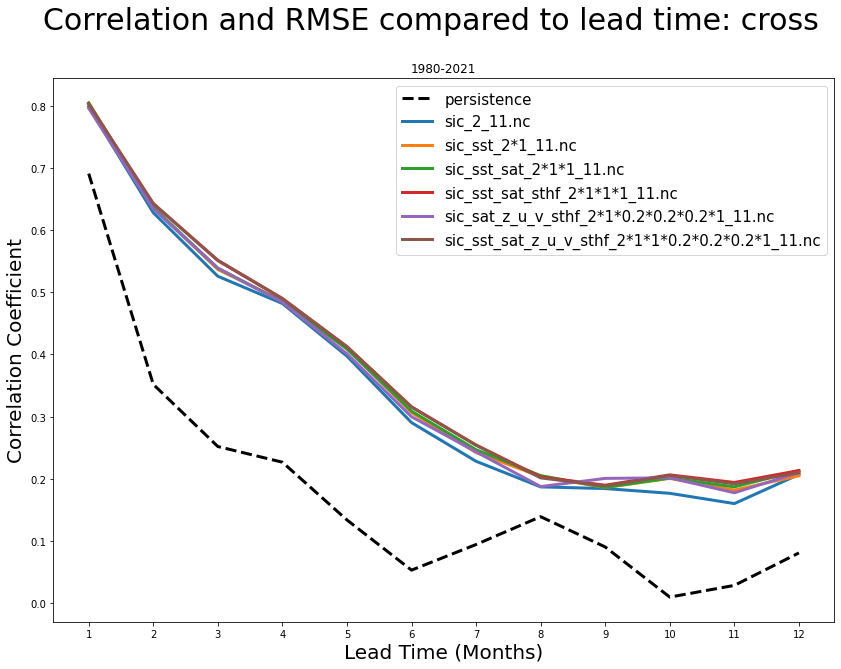

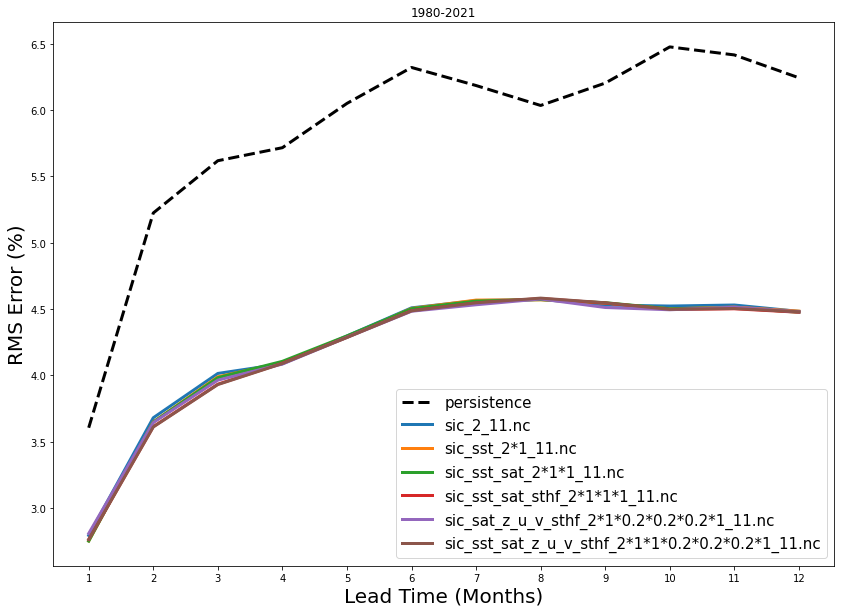

In [83]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', final_comps, dp2_region)

# of zz matrices: 6
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sst_sat_2*1*1_11.nc
sic_sst_sat_sthf_2*1*1*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


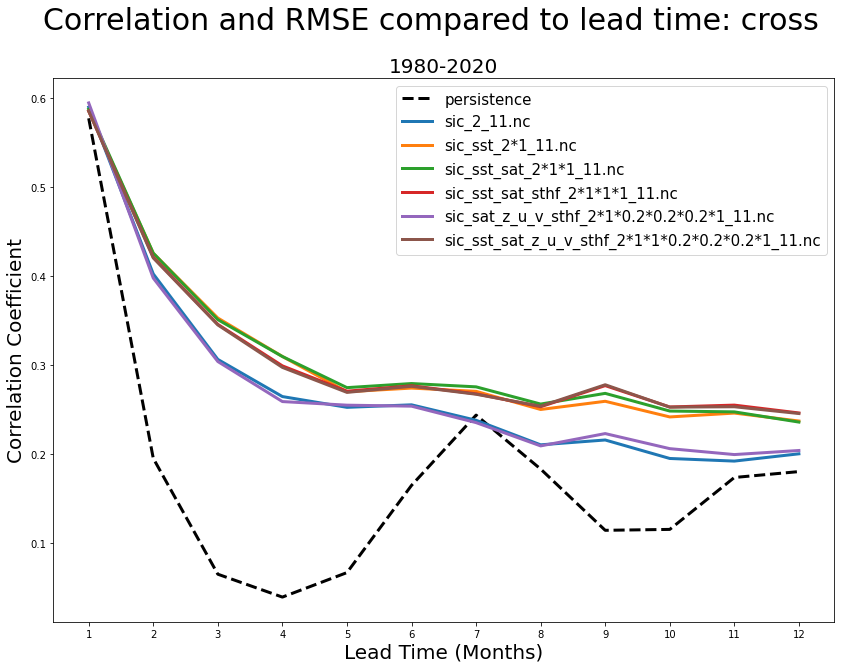

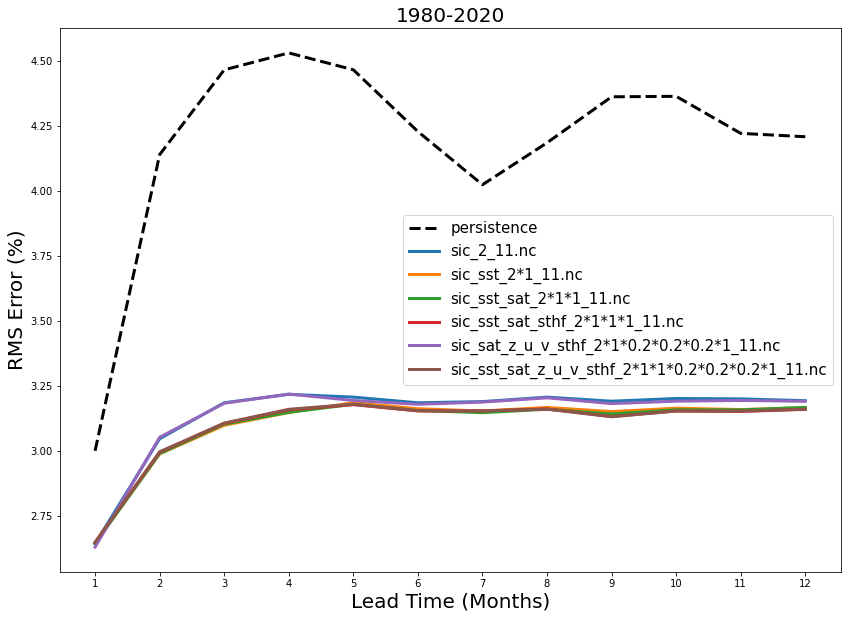

In [67]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', final_comps, e1_region)

# Using just four (FIGS I PROBS PUT ON THE POSTER)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


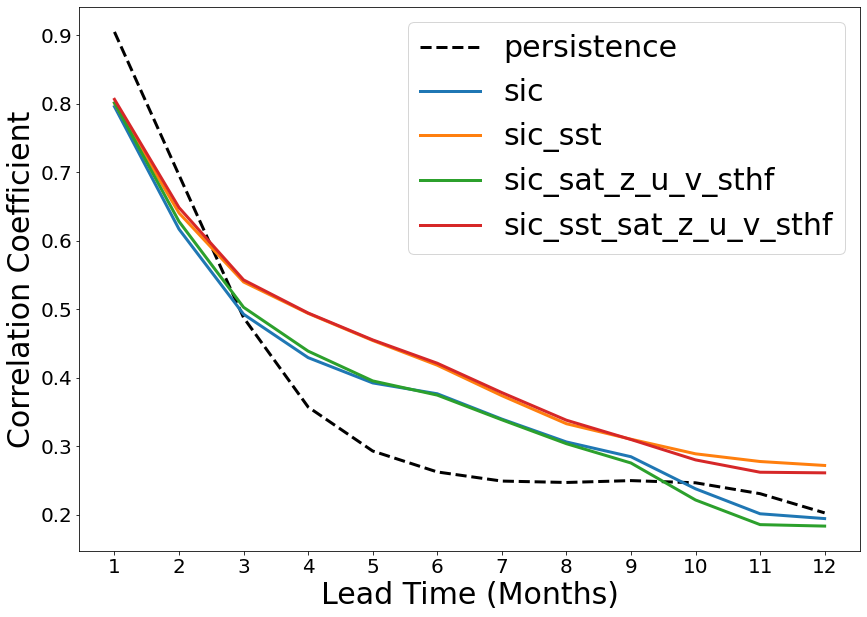

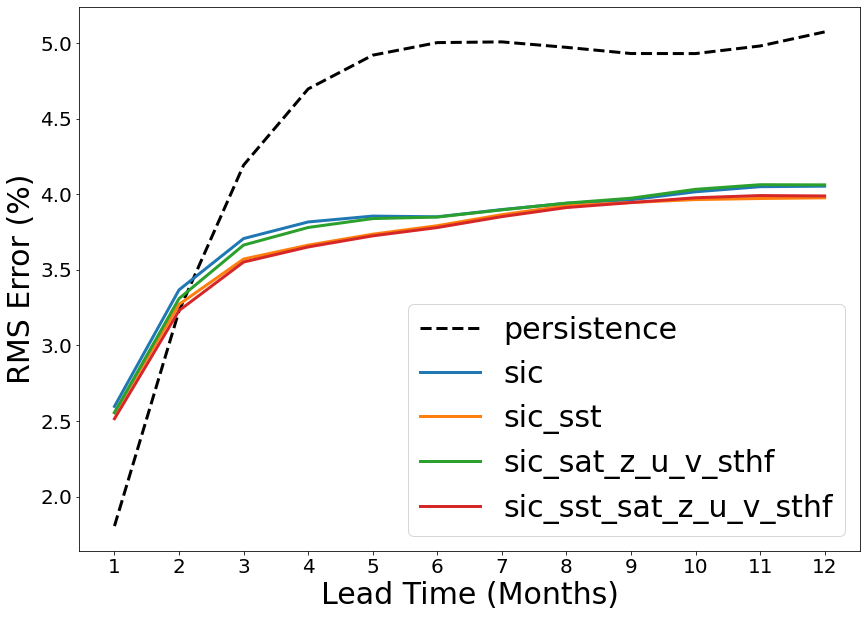

In [34]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, dp1_region, corr_legend)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


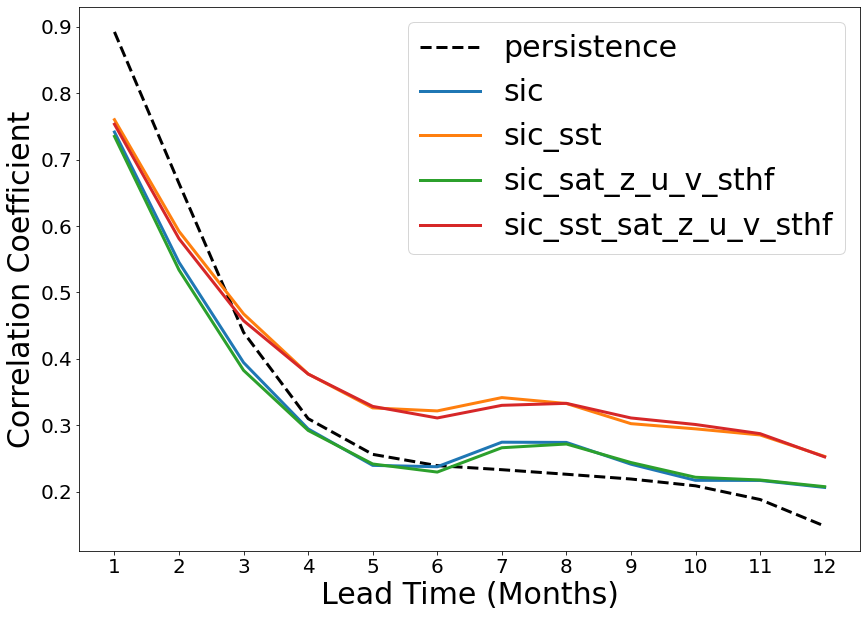

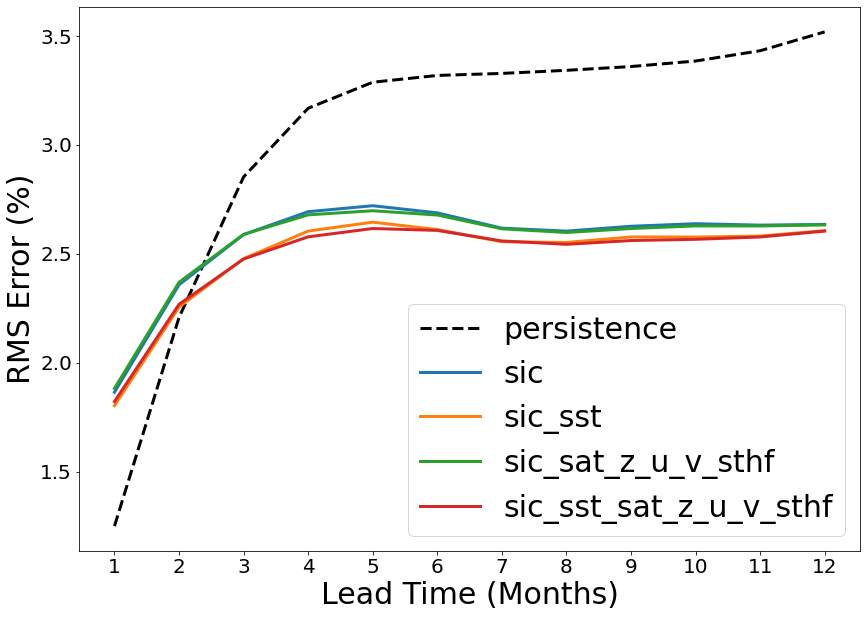

In [35]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, e2_region, corr_legend)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


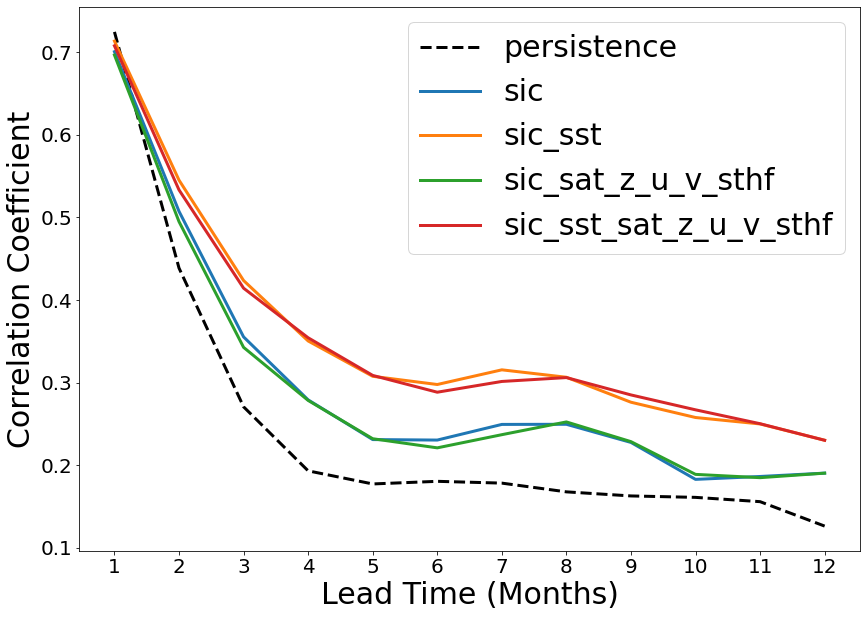

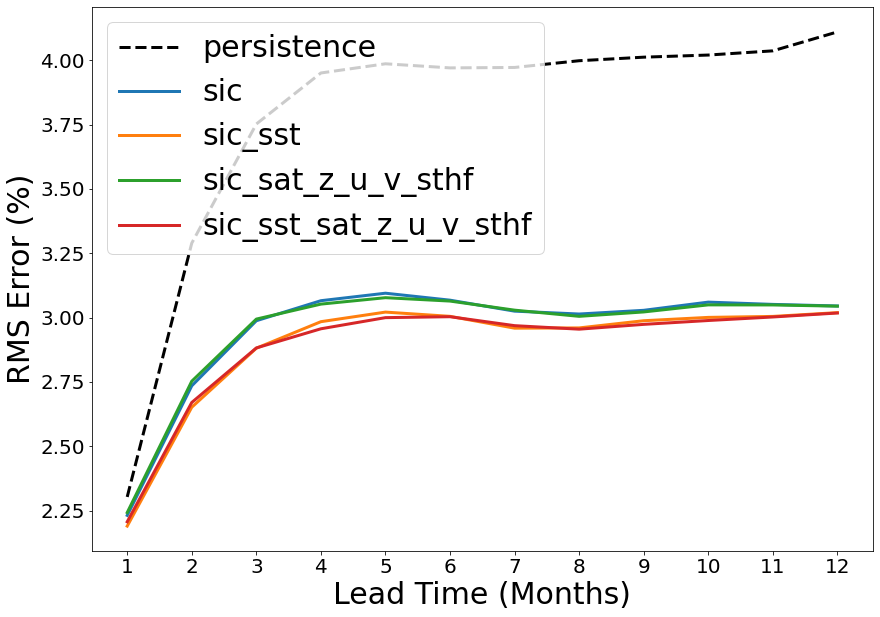

In [23]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, e2_region, corr_legend)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


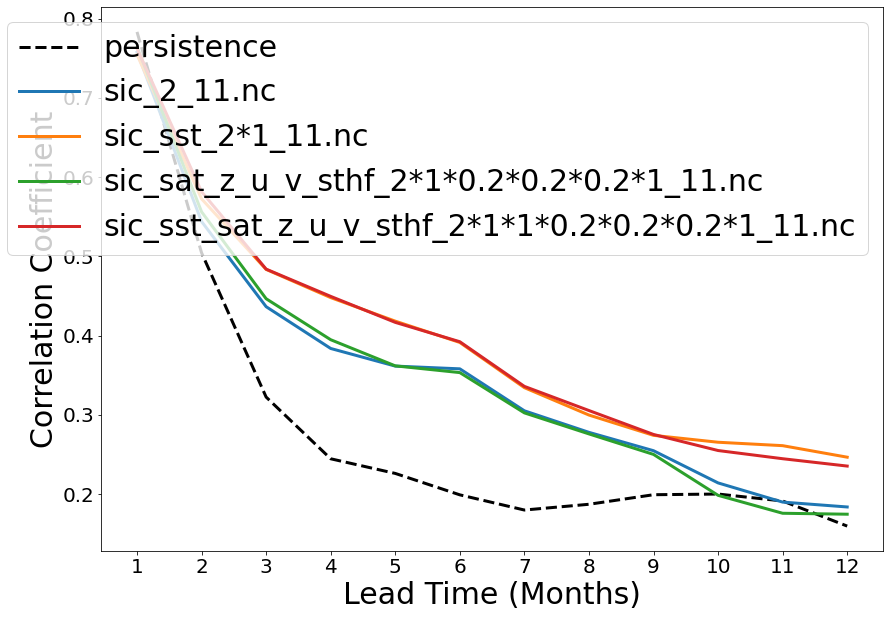

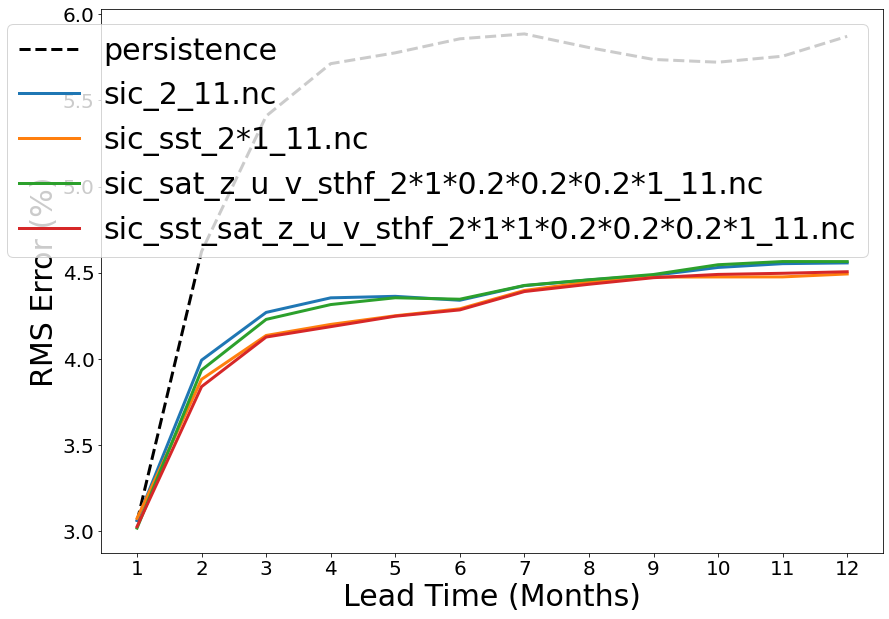

In [24]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, dp1_region)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


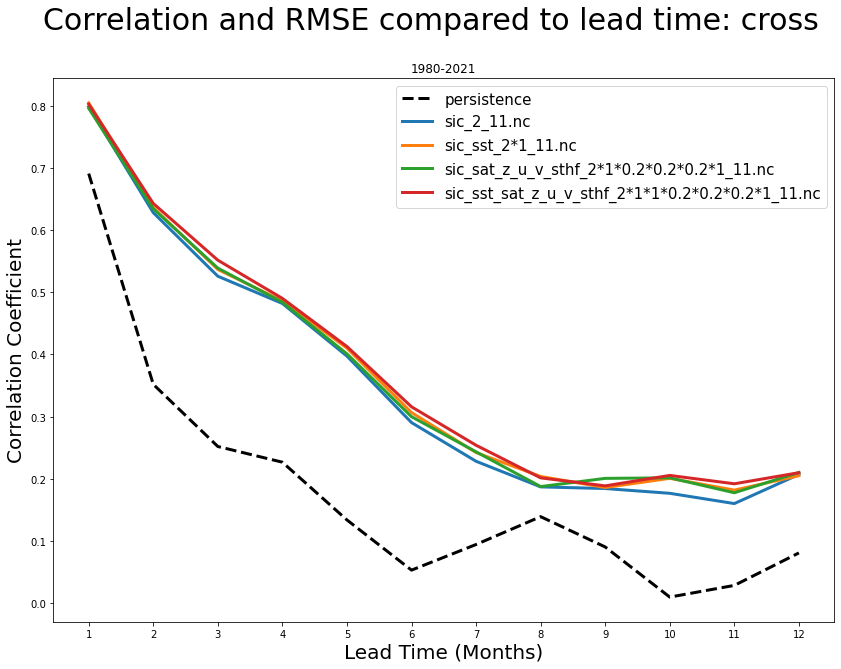

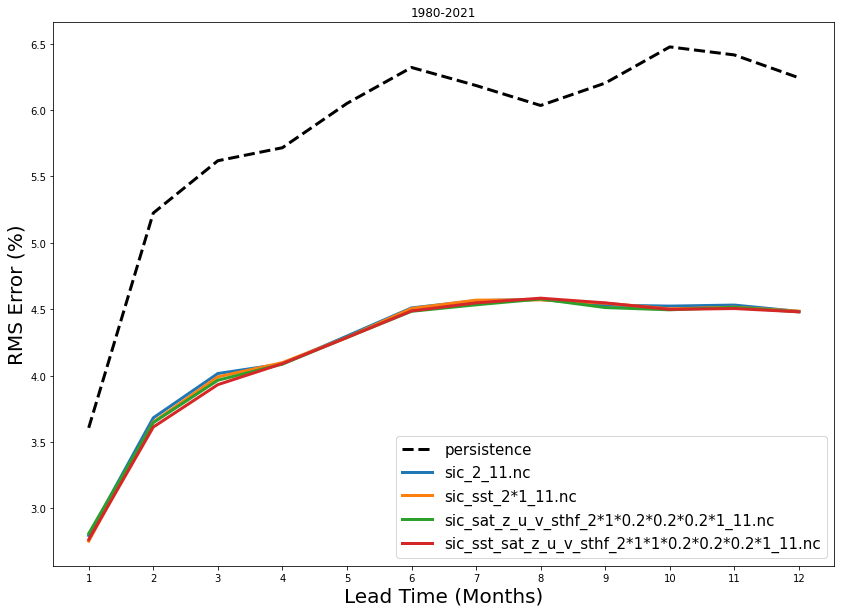

In [88]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, dp2_region)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


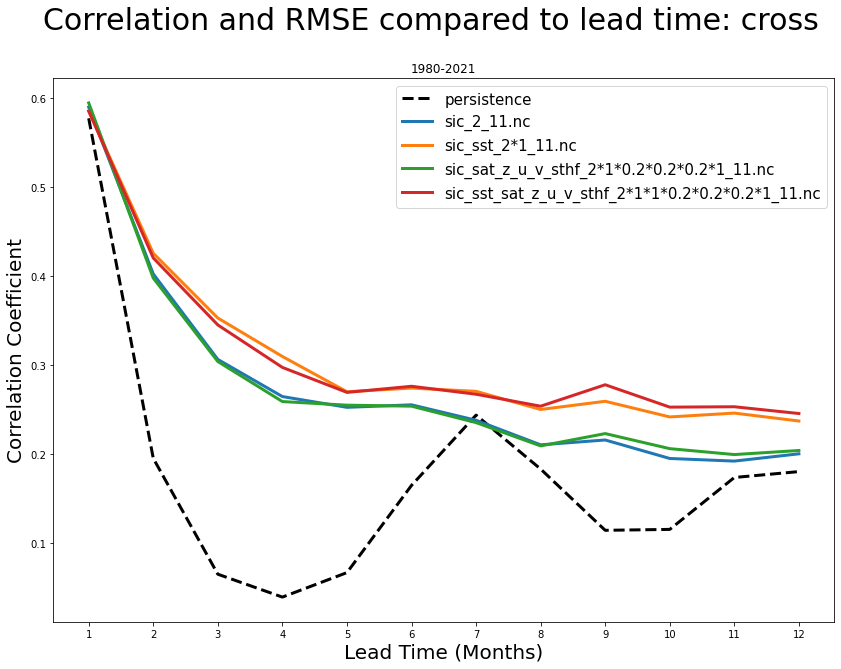

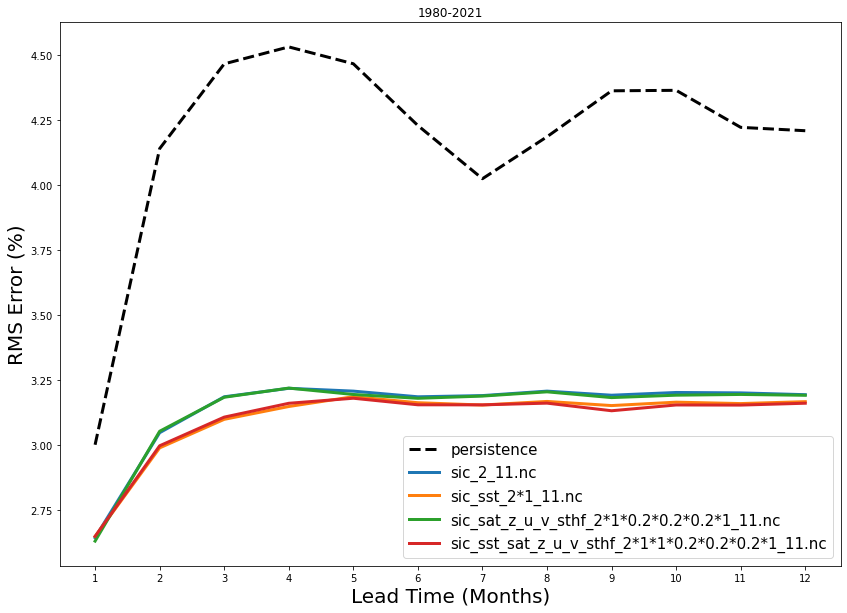

In [128]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, e1_region)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


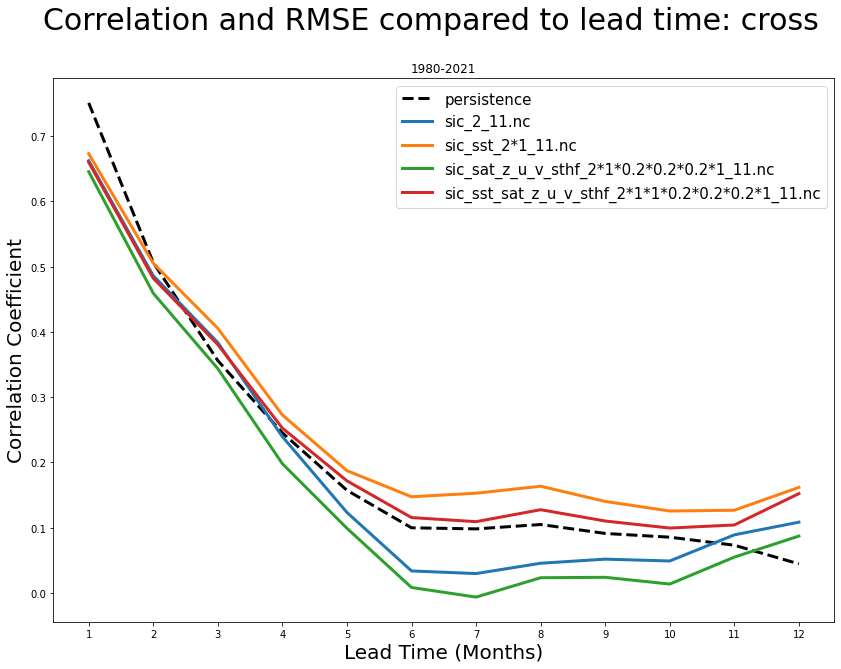

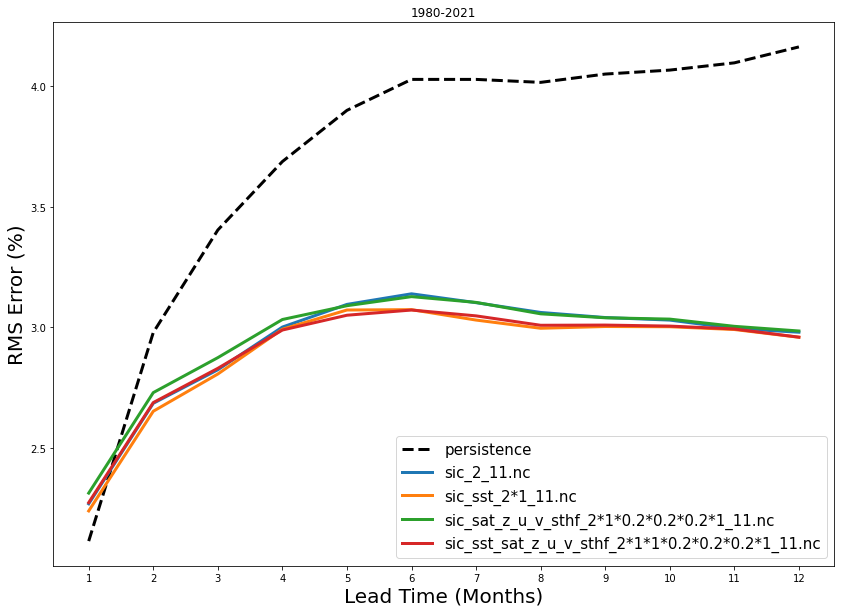

In [130]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, e3_region)

# of zz matrices: 4
sic_2_11.nc
sic_sst_2*1_11.nc
sic_sat_z_u_v_sthf_2*1*0.2*0.2*0.2*1_11.nc
sic_sst_sat_z_u_v_sthf_2*1*1*0.2*0.2*0.2*1_11.nc


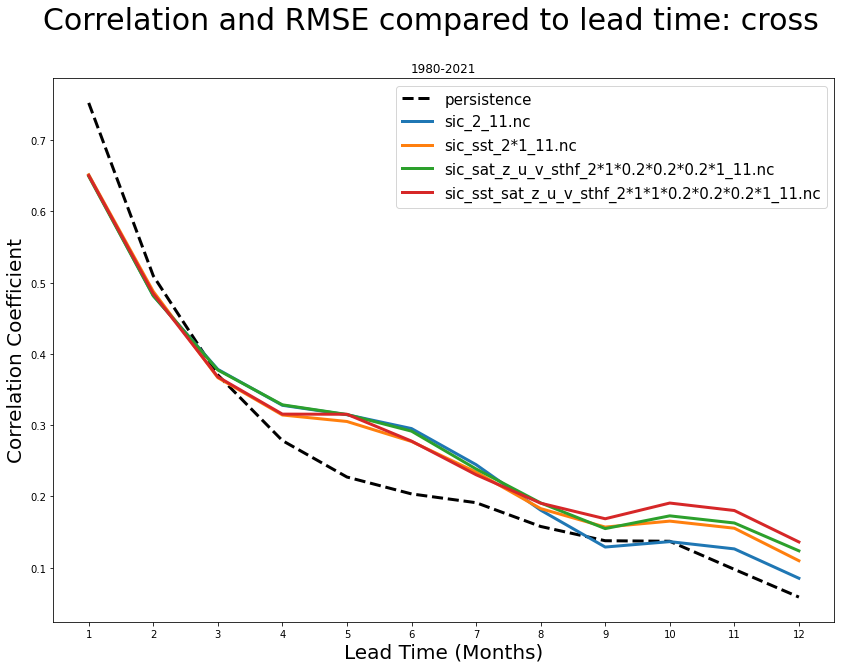

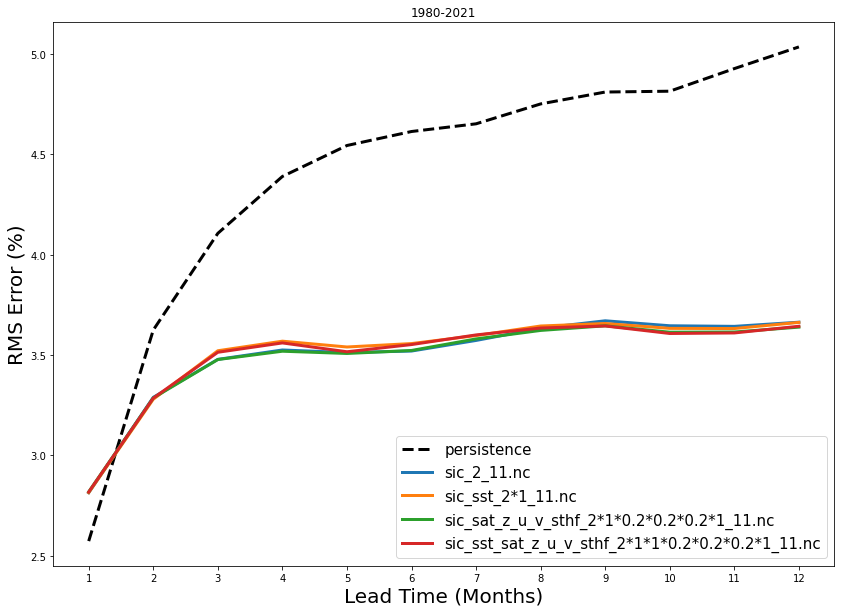

In [131]:
f, c, r, t, z, pc, pr = leadtime_plot_fnames_rindex('cross', diff_looks, e4_region)

### Some of the more final figures / Comparing weights down here

In [ ]:
#wgts_corrs, wgts_rmse = leadtime_plot_weights(f_start, 20, entire_region)

In [ ]:
f_names = ['sic_sst_sat_sthf_1*1*1*1_20.nc',
           'sic_sst_sat_sthf_2*1*1*1_20.nc',
           'sic_sst_sat_sthf_20.nc']
leadtime_plot_fnames(f_names, entire_region)